## Saving MERRA-2 Indices in .pkl
### Indices are derived from anomalies from the detrended data and then normalized<br>
### Indices include: EPC1, EPC2, PSA1, PSA2, SAM,  , ASL Rel CP Value, ASL Abs CP Value, ASL CP lon, ASL CP lat
### Now includes Southern Oscillation and Nino3.4 (15Jan2019)
### Indice time periods include: DJF, MAM, JJA, SON, 3- 6- 12- Month Roll, Annual Mean, and 2-7-yr bandpass filter

### 27Nov2018 Update includes improved way to calculate ASL Components


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.path as mpath
import datetime
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import signal
from IPython.display import display
import xarray as xr
import dask as da
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.array.rechunk import rechunk
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import statsmodels.api as sm

#for era
from eofs.xarray import Eof
from eofs.examples import example_data_path
np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [2]:
############# to be set #############

##Save figure file path
PICKLE_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_Indices_as_CSV_19Nov2018'

##Save .nc file path
NETCDF_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'

##Specific to MERRA2, ie, not the same chunk and slices as iCESM
XCHUNK = 240 #Full size chunk seems to make things run quickest
YCHUNK = 121 #Full Y size chunk makes things run quickest
#ZCHUNK = 30 #Full Z size chunk 
TCHUNK = 456  #Full T size (198001-201712) -- One year less that ERA-Interim


In [3]:
#For ERA, decode_cf needs to be set to True for proper concatenation on T axis
merra_disk = xr.open_dataset(NETCDF_PATH+'/MERRA_DATA.nc')
print(merra_disk)
era_disk = xr.open_dataset(NETCDF_PATH+'/ERA_DATA.nc')
print(era_disk)

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 240, time: 456)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
Data variables:
    skint    (time, lat, lon) float32 ...
    sst      (time, lat, lon) float32 ...
    msl      (time, lat, lon) float32 ...
    u10      (time, lat, lon) float32 ...
    v10      (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
    ci       (time, lat, lon) float32 ...
<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 240, time: 468)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2017-12-01
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
Data variables:
    sst

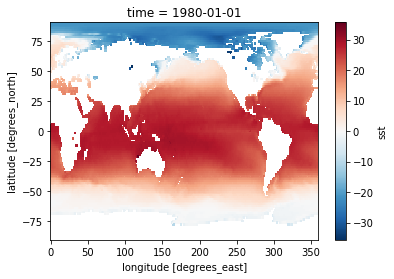

In [4]:
merra_disk.sst[0].plot()

In [5]:
#getting variables in right units 

In [6]:
slp_tmon_merra = merra_disk.msl/100 #hPa
v10_tmon_merra = merra_disk.v10 #in m/s at 10m
u10_tmon_merra = merra_disk.u10 #in m/s at 10m
t2m_tmon_merra = merra_disk.t2m-273.15 #in C
tp_tmon_merra  = merra_disk.tp*60*60*24*1000/1000  #in mm/day
ci_tmon_merra  = merra_disk.ci #in [0-1] fraction of sea ice
sst_tmon_merra = merra_disk.sst #SST in C -- taken care of when making the xarray/.nc file

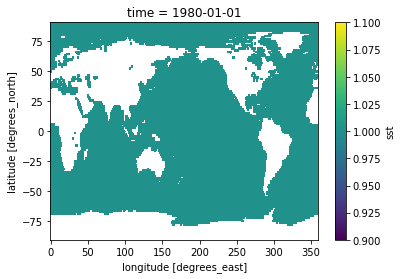

In [7]:
landsea_mask = sst_tmon_merra[0]/sst_tmon_merra[0]
# landsea_mask_coords = xr.DataArray(landsea_mask, coords={'lat': MERRA1_DATA.coords['lat'],'lon': MERRA1_DATA.coords['lon']}, dims=('lat','lon'))
landsea_mask.plot()

## Create Indices for EPC1, EPC2, SAM, PSA1, PSA2,  , ASL Rel CP Vals, ASL Abs CP Vals, ASL CP Lons, and ASL CP Lats

### These indices will then be correlated to the field of climate anomalies in the South Pacific and surrounding land and ocean regions

## Calculate the Southern Oscillation Index
#### Using info. from https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensocycle/soi.shtml and http://www.cpc.ncep.noaa.gov/data/indices/ and http://www.cpc.ncep.noaa.gov/data/indices/Readme.index.shtml#SOICALC

#### How is the SOI Calculated?

Note the anomalies are departures from the 1981-2010 base period.

#### 1.
Standard Deviation Tahiti = SQRT( SUMMATION(1) / N )

SUMMATION(1) - is the sum of all ((TA) ** 2),
TA - Tahiti anomaly = (actual(SLP) - mean(SLP)),
N - number of months

So, Standardized Tahiti = (Actual Tahiti (SLP) - Mean Tahiti (SLP))/Standard Deviation Tahiti

#### 2.
Standard Deviation Darwin = SQRT( SUMMATION(1) / N )

SUMMATION(1) - is the sum of all ((DA) ** 2),
DA - Darwin anomaly = (actual(SLP) - mean(SLP)),
N - number of months

So, Standardized Darwin = (Actual Darwin (SLP) - Mean Darwin (SLP))/Standard Deviation Darwin

#### 3.
To calculate the monthly standard deviation:

Monthly Standard Deviation (MSD) = SQRT( SUMMATION(3) / N)

SUMMATION(3) - is the sum of ((Standardized Tahiti - Standardized Darwin) ** 2),
N - total number of summed months

The SOI equation looks as follows: SOI = (Standardized Tahiti - Standardized Darwin) / MSD 

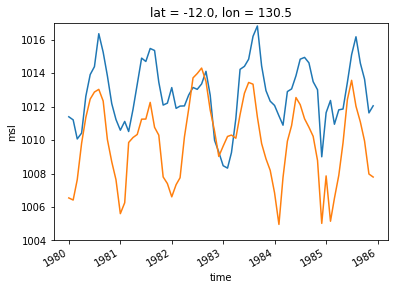

In [8]:
#params to be set

#Time period to calc seasonal (monthly) cycle:
time_lo     = '1980-01-01'
time_hi    = '2017-12-01'

#Darwin and Tahiti location
#Tahiti SLP Record(17.65S, 149.43W=210.57E)
slp_tahiti_tmon_merra = slp_tmon_merra.sel(time=slice(time_lo, time_hi)).sel(lat=-17.65, lon=210.57, method='nearest')
slp_tahiti_tmon_merra[0:72].plot()

#Darwin SLP Record (12.46S, 130.85E)
slp_darwin_tmon_merra = slp_tmon_merra.sel(time=slice(time_lo, time_hi)).sel(lat=-12.46, lon=130.85, method='nearest')
slp_darwin_tmon_merra[0:72].plot()

plt.ylim([1004,1017])
plt.show()

<xarray.DataArray 'msl' ()>
array(1.115136)
Coordinates:
    lat      float64 -18.0
    lon      float64 210.0


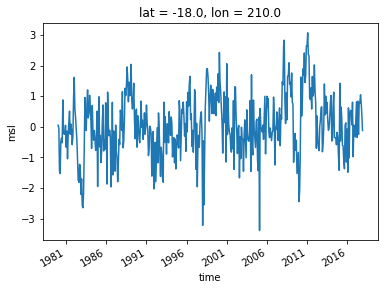

In [9]:
#Step 1
slp_tahiti_1981_2010_monthly_climatology_merra = slp_tahiti_tmon_merra.sel(time=slice('1981-01-01', '2010-12-31')).groupby('time.month').mean('time')
# slp_tahiti_1981_2010_monthly_climatology_merra.plot()
slp_tahiti_anomaly_tmon_merra = (slp_tahiti_tmon_merra.groupby('time.month') - slp_tahiti_1981_2010_monthly_climatology_merra)
# slp_tahiti_anomaly_tmon_merra.plot()
slp_tahiti_anomaly_squared_tmon_merra = slp_tahiti_anomaly_tmon_merra**(2)
slp_tahiti_anomaly_squared_sum_tmon_merra = slp_tahiti_anomaly_squared_tmon_merra.sum(axis=0)
std_tahiti = (slp_tahiti_anomaly_squared_sum_tmon_merra/len(slp_tahiti_tmon_merra.time))**(0.5)
print(std_tahiti)

standardized_tahiti = slp_tahiti_anomaly_tmon_merra/std_tahiti
standardized_tahiti.plot()

<xarray.DataArray 'msl' ()>
array(1.060573)
Coordinates:
    lat      float64 -12.0
    lon      float64 130.5


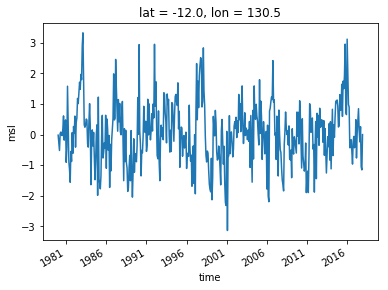

In [10]:
#Step 2
slp_darwin_1981_2010_monthly_climatology_merra = slp_darwin_tmon_merra.sel(time=slice('1981-01-01', '2010-12-31')).groupby('time.month').mean('time')
# slp_darwin_1981_2010_monthly_climatology_merra.plot()
slp_darwin_anomaly_tmon_merra = (slp_darwin_tmon_merra.groupby('time.month') - slp_darwin_1981_2010_monthly_climatology_merra)
# slp_darwin_anomaly_tmon_merra.plot()
slp_darwin_anomaly_squared_tmon_merra = slp_darwin_anomaly_tmon_merra**(2)
slp_darwin_anomaly_squared_sum_tmon_merra = slp_darwin_anomaly_squared_tmon_merra.sum(axis=0)
std_darwin = (slp_darwin_anomaly_squared_sum_tmon_merra/len(slp_darwin_tmon_merra.time))**(0.5)
print(std_darwin)

standardized_darwin = slp_darwin_anomaly_tmon_merra/std_darwin
standardized_darwin.plot()

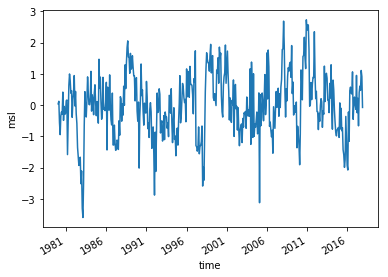

In [11]:
#Step 3
standardized_diff_squared = (standardized_tahiti - standardized_darwin)**2
monthly_std_msd = (standardized_diff_squared.sum(axis=0)/len(standardized_diff_squared.time))**(0.5)
soi_tmon_merra = (standardized_tahiti - standardized_darwin)/monthly_std_msd
soi_tmon_merra.plot()

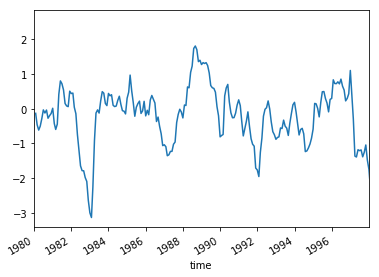

In [12]:
#With rolling mean, looks similar to https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensocycle/soi.shtml
soi_3roll_merra = soi_tmon_merra[:].rolling(time=3, min_periods=3, center=True).mean()
soi_3roll_merra.plot()
plt.xlim(['1980-01-01','1997-12-31'])
plt.show()

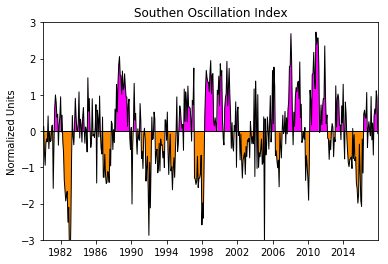

In [13]:
#SOI without 3 mon roll
fig, ax1 = plt.subplots()


sns.set_style('white')
sns.set_style('ticks',
              {'xtick.major.size':8, 'ytick.major.size':8,
               'xtick.direction': 'in', 'ytick.direction': 'in',
               'axes.linewidth':2 })
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 3),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}



x = soi_tmon_merra.time.values
y1 = soi_tmon_merra.values  ###Check to see if I need to Multiply by -1 to get sign correct###

ax1.set_title('Southen Oscillation Index')
ax1.set_ylim(-3,3)
ax1.yaxis.set_ticks(np.arange(-3, 4, 1))
ax1.set_ylabel('Normalized Units')
ax1.set_xlim(soi_tmon_merra.time.values[0],soi_tmon_merra.time.values[len(soi_tmon_merra.time)-1])
ax1.plot(x, y1, color='k',linewidth=1.0)
ax1.fill_between(x, 0, y1, where=y1 > 0, facecolor='magenta')
ax1.fill_between(x, 0, y1, where=y1 < 0, facecolor='darkorange')
ax1.axhline(y=0, linewidth=1.0, color='k')

plt.show()

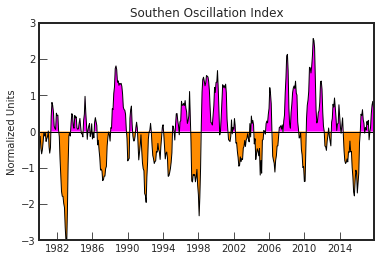

In [14]:
#SOI with 3 mon roll
fig, ax1 = plt.subplots()


sns.set_style('white')
sns.set_style('ticks',
              {'xtick.major.size':8, 'ytick.major.size':8,
               'xtick.direction': 'in', 'ytick.direction': 'in',
               'axes.linewidth':2 })
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 3),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}



x = soi_3roll_merra.time.values
y1 = soi_3roll_merra.values  ###Check to see if I need to Multiply by -1 to get sign correct###

ax1.set_title('Southen Oscillation Index')
ax1.set_ylim(-3,3)
ax1.yaxis.set_ticks(np.arange(-3, 4, 1))
ax1.set_ylabel('Normalized Units')
ax1.set_xlim(soi_3roll_merra.time.values[0],soi_3roll_merra.time.values[len(soi_3roll_merra.time)-1])
ax1.plot(x, y1, color='k',linewidth=1.0)
ax1.fill_between(x, 0, y1, where=y1 > 0, facecolor='magenta')
ax1.fill_between(x, 0, y1, where=y1 < 0, facecolor='darkorange')
ax1.axhline(y=0, linewidth=1.0, color='k')

plt.show()

#With rolling mean, looks similar to https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensocycle/soi.shtml

#### Do I want to use this 3 month roll data set to create the seasonal averages and annual averages? and rolls?
I would say no.... each seasonal mean is a 3 month mean... <br> <br>
#### Save tmon, seasonals, ann, and rolls, and 2-7 band pass

In [15]:
#Finalize SOI index and put into pandas dataframE
df_soi_tmon_merra = pd.DataFrame(soi_tmon_merra.values)
df_soi_tmon_merra.columns = ['SOI']
df_soi_tmon_merra

df_time_soi_tmon_merra = pd.DataFrame(soi_tmon_merra.coords['time'].values)
df_time_soi_tmon_merra.columns = ['time']
df_time_soi_tmon_merra

soi_index_tmon_merra = pd.concat([df_time_soi_tmon_merra, df_soi_tmon_merra], axis=1)

soi_index_tmon_merra.to_pickle(PICKLE_PATH+'/merra_soi_tmon.pkl')

soi_index_tmon_merra.head(n=5)

#Note, I am not smoothing the time series by 3 months bc I end up looking at seasonal means which is essentially
#a smoothing of three months

,time,SOI
0,1980-01-01,0.041786
1,1980-02-01,0.124264
2,1980-03-01,-0.556985
3,1980-04-01,-0.943119
4,1980-05-01,-0.341701


In [16]:
#Make time the index column so that we can use resample for seasonal means
soi_index_tmon_merra.time = pd.to_datetime(soi_index_tmon_merra.time)
soi_index_tmon_merra.set_index('time', inplace=True)
soi_index_tmon_merra

#DataFrame of SOI Index as Seasonal Means, from 1979 MAM through 2017 SON
soi_index_seas_mean_merra = soi_index_tmon_merra[2:(len(soi_index_tmon_merra['SOI'])-1)].resample('3MS', closed='left'  ).mean()
soi_index_seas_mean_merra

soi_index_seas_mean_merra['Seas_Index'] = soi_index_seas_mean_merra.index.astype(str).str[5:7]
soi_index_seas_mean_merra
soi_index_seas_mean_merra.to_pickle(PICKLE_PATH+'/merra_soi_seas.pkl')

soi_index_seas_mean_merra.head(n=5)

,SOI,Seas_Index
time,,
1980-03-01,-0.613935,03
1980-06-01,-0.031362,06
1980-09-01,-0.272170,09
1980-12-01,0.015959,12
1981-03-01,-0.442422,03


In [17]:
#DataFrame of SOI as annual Means, from 1979 Jan through 2017
soi_index_ann_mean_merra = soi_index_tmon_merra[:].resample('AS', closed='left'  ).mean()

soi_index_ann_mean_merra.to_pickle(PICKLE_PATH+'/merra_soi_ann_mean.pkl')

soi_index_ann_mean_merra.head(n=5)


,SOI
time,
1980-01-01,-0.237114
1981-01-01,0.150344
1982-01-01,-1.041146
1983-01-01,-0.719031
1984-01-01,0.183613


In [18]:
#DataFrame of SOI as 12 month rolling means (centered), from 1979-2017
soi_index_12roll_merra = soi_index_tmon_merra[:].rolling(12, min_periods=12, center=True).mean()

soi_index_12roll_merra.to_pickle(PICKLE_PATH+'/merra_soi_12roll_mean.pkl')

soi_index_12roll_merra.head(n=10)


,SOI
time,
1980-01-01,NaN
1980-02-01,NaN
1980-03-01,NaN
1980-04-01,NaN
1980-05-01,NaN
1980-06-01,NaN
1980-07-01,-0.237114
1980-08-01,-0.228787
1980-09-01,-0.225377


In [19]:
#DataFrame of SOI as 6 month rolling means (centered), from 1979-2017
soi_index_6roll_merra = soi_index_tmon_merra[:].rolling(6, min_periods=6, center=True).mean()

soi_index_6roll_merra.to_pickle(PICKLE_PATH+'/merra_soi_6roll_mean.pkl')

soi_index_6roll_merra.head(n=10)


,SOI
time,
1980-01-01,NaN
1980-02-01,NaN
1980-03-01,NaN
1980-04-01,-0.315522
1980-05-01,-0.371624
1980-06-01,-0.322649
1980-07-01,-0.310956
1980-08-01,-0.160160
1980-09-01,-0.151766


In [20]:
#DataFrame of SOI as 3 month rolling means (centered), from 1979-2017
soi_index_3roll_merra = soi_index_tmon_merra[:].rolling(3, min_periods=3, center=True).mean()

soi_index_3roll_merra.to_pickle(PICKLE_PATH+'/merra_soi_3roll_mean.pkl')

soi_index_3roll_merra.head(n=10)


,SOI
time,
1980-01-01,NaN
1980-02-01,-0.130311
1980-03-01,-0.458613
1980-04-01,-0.613935
1980-05-01,-0.500732
1980-06-01,-0.284635
1980-07-01,-0.031362
1980-08-01,-0.121180
1980-09-01,-0.035685


**Gather the 2-7-yr band pass filter for the SOI**<br>

Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [21]:
# def filt_but_low(tab,cutoff,samp,btype='lowpass',N=2):
#    """Butterworth filter with
#       tab : array to be filtered (assume that first dimension is time
#       N : filter order (polynom)
#       cutoff : cutoff period in units of basic period (days, months years etc.)
#       samp : sampling rate in same units
#    """
#    # First, design the Butterworth filter
#    N  = 2
#    Wn = samp/cutoff
#    B, A = signal.butter(N, Wn,btype=btype, output='ba')
#    # Second: padding on left and right
#    L  = int(np.round(cutoff/samp))    # determine length of padding
#    M  = tab.shape[0]
#    pl = np.flipud(tab[1:L+1,...])  # padding on left
#    pr = np.flipud(tab[M-L-1:M-1,...])  # padding on right
#    tab_pad = np.zeros(tab.shape[1:])*np.ones((tab.shape[0]+2*L,1,1))
#    tab_pad = tab_pad.squeeze()
#    tab_pad[:L,...]=pl
#    tab_pad[L:M+L,...]=tab
#    tab_pad[M+L:M+2*L,...]=pr
#    # Third: apply the filter
#    tab_filt = signal.filtfilt(B,A, tab_pad,axis=0)
#    return tab_filt[L:tab_pad.shape[0]-L,...]

In [22]:
def filt_but_band(tab,cutoff_lo,cutoff_hi,samp,btype='bandpass',N=2):
   """Butterworth filter with
      tab : array to be filtered (assume that first dimension is time
      N : filter order (polynom)
      cutoff : cutoff period in units of basic period (days, months years etc.)
      samp : sampling rate in same units
   """
   # First, design the Butterworth filter
   N  = 2
   Wn_lo = samp/cutoff_lo
   Wn_hi = samp/cutoff_hi    
   B, A = signal.butter(N, (Wn_lo,Wn_hi), btype=btype, output='ba')
   # Second: padding on left and right
   L  = int(np.round(cutoff_lo/samp))    # determine length of padding
   M  = tab.shape[0]
   pl = np.flipud(tab[1:L+1,...])  # padding on left
   pr = np.flipud(tab[M-L-1:M-1,...])  # padding on right
   tab_pad = np.zeros(tab.shape[1:])*np.ones((tab.shape[0]+2*L,1,1))
   tab_pad = tab_pad.squeeze()
   tab_pad[:L,...]=pl
   tab_pad[L:M+L,...]=tab
   tab_pad[M+L:M+2*L,...]=pr
   # Third: apply the filter
   tab_filt = signal.filtfilt(B,A, tab_pad,axis=0)
   return tab_filt[L:tab_pad.shape[0]-L,...]

In [23]:
#SOI 2 to 7 yr band pass filter
soi_index_band_filt_merra = filt_but_band(soi_index_tmon_merra.SOI.values,84.,24.,1.,btype='bandpass',N=2)

#Finalize BANDPASS FILTERED SOI and put into pandas dataframE
df_soi_index_band_filt_merra = pd.DataFrame(soi_index_band_filt_merra)
df_soi_index_band_filt_merra.columns = ['SOI']
df_soi_index_band_filt_merra

df_time_soi_tmon_merra = pd.DataFrame(soi_tmon_merra.coords['time'].values)
df_time_soi_tmon_merra.columns = ['time']
df_time_soi_tmon_merra

soi_index_band_filt_merra = pd.concat([df_time_soi_tmon_merra, df_soi_index_band_filt_merra], axis=1)
soi_index_band_filt_merra.set_index('time', inplace=True)

soi_index_band_filt_merra.to_pickle(PICKLE_PATH+'/merra_soi_band_filt.pkl')

soi_index_band_filt_merra.head(n=5)


,SOI
time,
1980-01-01,0.317424
1980-02-01,0.314841
1980-03-01,0.310514
1980-04-01,0.304433
1980-05-01,0.296553


## Nino 3.4 Index

Niño 3.4 (5N-5S, 170W-120W):  The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast.  The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La  Niña events are defined when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more. <br>
Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period.

In [24]:
#Define the Tropical Pacific Region for Nino3.4
nino34_xhi = 240
nino34_xlo = 190
nino34_yhi = -5 #Had to reverse hi and lo lat values for ERA&MERRA
nino34_ylo = 5  #Had to reverse hi and lo lat values for ERA&MERRA

In [25]:
#Nino3.4 area mean SST
nino34_area_mean_sst_merra = sst_tmon_merra.sel(time=slice(time_lo, time_hi),lat=slice(nino34_ylo,nino34_yhi)
                                            ,lon=slice(nino34_xlo,nino34_xhi)).mean(axis=(1,2))
# nino34_area_mean_sst_merra.plot()

#Nino3.4 area mean SST -Climatology (use 1981-2010)
nino34_area_mean_sst_climatology_merra = nino34_area_mean_sst_merra.sel(time=slice('1981-01-01', '2010-12-31')).groupby('time.month').mean('time')
nino34_area_mean_sst_anomaly_tmon_merra = (nino34_area_mean_sst_merra.groupby('time.month') - nino34_area_mean_sst_climatology_merra)
# nino34_area_mean_sst_anomaly_tmon_merra.plot()

#NOTE, not going to smooth by 5-months!
#So skip smoothing, but still normalize by standard deviation over the climatological period
nino34_area_mean_sst_anoms_std_during_climatology_merra = nino34_area_mean_sst_anomaly_tmon_merra.sel(time=slice('1981-01-01', '2010-12-31')).std()
# print(nino34_area_mean_sst_anoms_std_during_climatology_merra)

nino34_index_tmon_merra = nino34_area_mean_sst_anomaly_tmon_merra/nino34_area_mean_sst_anoms_std_during_climatology_merra
# nino34_index_tmon_merra.std()

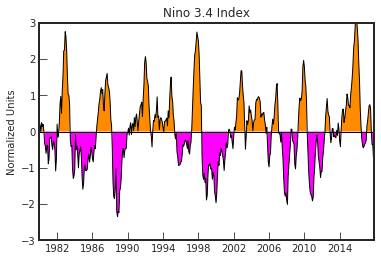

In [26]:
#Nino3.4 without 5 mon roll
fig, ax1 = plt.subplots()


sns.set_style('white')
sns.set_style('ticks',
              {'xtick.major.size':8, 'ytick.major.size':8,
               'xtick.direction': 'in', 'ytick.direction': 'in',
               'axes.linewidth':2 })
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 3),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}



x = nino34_index_tmon_merra.time.values
y1 = nino34_index_tmon_merra.values  ###Check to see if I need to Multiply by -1 to get sign correct###

ax1.set_title('Nino 3.4 Index')
ax1.set_ylim(-3,3)
ax1.yaxis.set_ticks(np.arange(-3, 4, 1))
ax1.set_ylabel('Normalized Units')
ax1.set_xlim(nino34_index_tmon_merra.time.values[0],nino34_index_tmon_merra.time.values[len(nino34_index_tmon_merra.time)-1])
ax1.plot(x, y1, color='k',linewidth=1.0)
ax1.fill_between(x, 0, y1, where=y1 > 0, facecolor='darkorange')
ax1.fill_between(x, 0, y1, where=y1 < 0, facecolor='magenta')
ax1.axhline(y=0, linewidth=1.0, color='k')

plt.show()

#### Note, not using a smoothed by 5-month nino3.4 index
#### Save tmon, seasonals, ann, and rolls, and 2-7 band pass

In [27]:
#Finalize nino34 index and put into pandas dataframE
df_nino34_index_tmon_merra = pd.DataFrame(nino34_index_tmon_merra.values)
df_nino34_index_tmon_merra.columns = ['NINO34']
# df_nino34_index_tmon_merra

df_time_nino34_index_tmon_merra = pd.DataFrame(nino34_index_tmon_merra.coords['time'].values)
df_time_nino34_index_tmon_merra.columns = ['time']
# df_time_nino34_index_tmon_merra

nino34_index_tmon_merra = pd.concat([df_time_nino34_index_tmon_merra, df_nino34_index_tmon_merra], axis=1)

nino34_index_tmon_merra.to_pickle(PICKLE_PATH+'/merra_nino34_tmon.pkl')

nino34_index_tmon_merra.head(n=5)

#Note, I am not smoothing the time series by 3 months bc I end up looking at seasonal means which is essentially
#a smoothing of three months

,time,NINO34
0,1980-01-01,0.248125
1,1980-02-01,0.164211
2,1980-03-01,-0.028988
3,1980-04-01,0.251431
4,1980-05-01,0.141694


In [28]:
#Make time the index column so that we can use resample for seasonal means
nino34_index_tmon_merra.time = pd.to_datetime(nino34_index_tmon_merra.time)
nino34_index_tmon_merra.set_index('time', inplace=True)
nino34_index_tmon_merra

#DataFrame of nino34 Index as Seasonal Means, from 1979 MAM through 2017 SON
nino34_index_seas_mean_merra = nino34_index_tmon_merra[2:(len(nino34_index_tmon_merra['NINO34'])-1)].resample('3MS', closed='left'  ).mean()
nino34_index_seas_mean_merra

nino34_index_seas_mean_merra['Seas_Index'] = nino34_index_seas_mean_merra.index.astype(str).str[5:7]
nino34_index_seas_mean_merra
nino34_index_seas_mean_merra.to_pickle(PICKLE_PATH+'/merra_nino34_seas.pkl')

nino34_index_seas_mean_merra.head(n=5)

,NINO34,Seas_Index
time,,
1980-03-01,0.121379,03
1980-06-01,-0.033266,06
1980-09-01,-0.467055,09
1980-12-01,-0.669581,12
1981-03-01,-0.165514,03


In [29]:
#DataFrame of nino34 as annual Means, from 1979 Jan through 2017
nino34_index_ann_mean_merra = nino34_index_tmon_merra[:].resample('AS', closed='left'  ).mean()

nino34_index_ann_mean_merra.to_pickle(PICKLE_PATH+'/merra_nino34_ann_mean.pkl')

nino34_index_ann_mean_merra.head(n=5)


,NINO34
time,
1980-01-01,-0.092055
1981-01-01,-0.497359
1982-01-01,1.027739
1983-01-01,0.385661
1984-01-01,-0.733871


In [30]:
#DataFrame of nino34 as 12 month rolling means (centered), from 1979-2017
nino34_index_12roll_merra = nino34_index_tmon_merra[:].rolling(12, min_periods=12, center=True).mean()

nino34_index_12roll_merra.to_pickle(PICKLE_PATH+'/merra_nino34_12roll_mean.pkl')

nino34_index_12roll_merra.head(n=10)


,NINO34
time,
1980-01-01,NaN
1980-02-01,NaN
1980-03-01,NaN
1980-04-01,NaN
1980-05-01,NaN
1980-06-01,NaN
1980-07-01,-0.092055
1980-08-01,-0.186755
1980-09-01,-0.262131


In [31]:
#DataFrame of nino34 as 6 month rolling means (centered), from 1979-2017
nino34_index_6roll_merra = nino34_index_tmon_merra[:].rolling(6, min_periods=6, center=True).mean()

nino34_index_6roll_merra.to_pickle(PICKLE_PATH+'/merra_nino34_6roll_mean.pkl')

nino34_index_6roll_merra.head(n=10)

,NINO34
time,
1980-01-01,NaN
1980-02-01,NaN
1980-03-01,NaN
1980-04-01,0.162155
1980-05-01,0.124421
1980-06-01,0.044057
1980-07-01,-0.018096
1980-08-01,-0.160080
1980-09-01,-0.250160


In [32]:
#DataFrame of nino34 as 3 month rolling means (centered), from 1979-2017
nino34_index_3roll_merra = nino34_index_tmon_merra[:].rolling(3, min_periods=3, center=True).mean()

nino34_index_3roll_merra.to_pickle(PICKLE_PATH+'/merra_nino34_3roll_mean.pkl')

nino34_index_3roll_merra.head(n=10)

,NINO34
time,
1980-01-01,NaN
1980-02-01,0.127783
1980-03-01,0.128885
1980-04-01,0.121379
1980-05-01,0.196527
1980-06-01,0.119958
1980-07-01,-0.033266
1980-08-01,-0.232719
1980-09-01,-0.440117


**Gather the 2-7-yr band pass filter for the SOI**<br>

Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [33]:
# def filt_but_low(tab,cutoff,samp,btype='lowpass',N=2):
#    """Butterworth filter with
#       tab : array to be filtered (assume that first dimension is time
#       N : filter order (polynom)
#       cutoff : cutoff period in units of basic period (days, months years etc.)
#       samp : sampling rate in same units
#    """
#    # First, design the Butterworth filter
#    N  = 2
#    Wn = samp/cutoff
#    B, A = signal.butter(N, Wn,btype=btype, output='ba')
#    # Second: padding on left and right
#    L  = int(np.round(cutoff/samp))    # determine length of padding
#    M  = tab.shape[0]
#    pl = np.flipud(tab[1:L+1,...])  # padding on left
#    pr = np.flipud(tab[M-L-1:M-1,...])  # padding on right
#    tab_pad = np.zeros(tab.shape[1:])*np.ones((tab.shape[0]+2*L,1,1))
#    tab_pad = tab_pad.squeeze()
#    tab_pad[:L,...]=pl
#    tab_pad[L:M+L,...]=tab
#    tab_pad[M+L:M+2*L,...]=pr
#    # Third: apply the filter
#    tab_filt = signal.filtfilt(B,A, tab_pad,axis=0)
#    return tab_filt[L:tab_pad.shape[0]-L,...]

In [34]:
def filt_but_band(tab,cutoff_lo,cutoff_hi,samp,btype='bandpass',N=2):
   """Butterworth filter with
      tab : array to be filtered (assume that first dimension is time
      N : filter order (polynom)
      cutoff : cutoff period in units of basic period (days, months years etc.)
      samp : sampling rate in same units
   """
   # First, design the Butterworth filter
   N  = 2
   Wn_lo = samp/cutoff_lo
   Wn_hi = samp/cutoff_hi    
   B, A = signal.butter(N, (Wn_lo,Wn_hi), btype=btype, output='ba')
   # Second: padding on left and right
   L  = int(np.round(cutoff_lo/samp))    # determine length of padding
   M  = tab.shape[0]
   pl = np.flipud(tab[1:L+1,...])  # padding on left
   pr = np.flipud(tab[M-L-1:M-1,...])  # padding on right
   tab_pad = np.zeros(tab.shape[1:])*np.ones((tab.shape[0]+2*L,1,1))
   tab_pad = tab_pad.squeeze()
   tab_pad[:L,...]=pl
   tab_pad[L:M+L,...]=tab
   tab_pad[M+L:M+2*L,...]=pr
   # Third: apply the filter
   tab_filt = signal.filtfilt(B,A, tab_pad,axis=0)
   return tab_filt[L:tab_pad.shape[0]-L,...]

In [35]:
#Nino34 2 to 7 yr band pass filter
nino34_index_band_filt_merra = filt_but_band(nino34_index_tmon_merra.NINO34.values,84.,24.,1.,btype='bandpass',N=2)

#Finalize BANDPASS FILTERED SOI and put into pandas dataframE
df_nino34_index_band_filt_merra = pd.DataFrame(nino34_index_band_filt_merra)
df_nino34_index_band_filt_merra.columns = ['NINO34']
df_nino34_index_band_filt_merra

df_time_nino34_index_tmon_merra = pd.DataFrame(nino34_index_tmon_merra.index.values)
df_time_nino34_index_tmon_merra.columns = ['time']
df_time_nino34_index_tmon_merra

nino34_index_band_filt_merra = pd.concat([df_time_nino34_index_tmon_merra, df_nino34_index_band_filt_merra], axis=1)
nino34_index_band_filt_merra.set_index('time', inplace=True)

nino34_index_band_filt_merra.to_pickle(PICKLE_PATH+'/merra_nino34_band_filt.pkl')

nino34_index_band_filt_merra.head(n=5)


,NINO34
time,
1980-01-01,-0.253373
1980-02-01,-0.250565
1980-03-01,-0.245162
1980-04-01,-0.237111
1980-05-01,-0.226327


**Calculate ENSO index (EP and CP) via EOFs and SST** <br>
Jeong (2017) A new method to classify ENSO events into eastern and central Pacific types
<br> <br>
The time series is calculated as follows:<br>
1a) Detrend Trop Pac SSTs (I added this step as I want to evaluate the dynamics, not the trend) <br>
1) Anomalies are calculated for each calender month with respect to time_low-time_high<br>
2) Calculate First two EOFs of the Tropical Pacific (20S-20N, 110E-70W) SST anoms<br>
3) Calculate the pattern correlation coefficient at each time step by finding the pearson correlation coef. of the vectorized (1D) values of the EOF1 and EOF2 maps (2D) and SST Anom maps (2D + time), these correlation coefficients are the Eastern and Central Pacific ENSO time series.<br>
4) The mean and standard deviation are adjusted to be 0 and 1, respectively, for the period 19790101-20171201, all calendar months combined. This allows for a normalized time series that can be compared to the way I calculated the SAM, PSA1, and PSA2 indices<br>
5) After smoothing by 5 months, these correlation coefficients are the Eastern and Central Pacific ENSO time series. I HAVE NOT SMOOTHED BY 5 MONTHS... NOT SURE IF I NEED TO IF I LOOK AT SEASONAL MEANS







In [36]:
#params to be set

#Time period to calc seasonal (monthly) cycle:
time_lo     = '1980-01-01'
time_hi    = '2017-12-01' 

#Define the Tropical Pacific per Jeong et al., (2017)
trop_pac_xhi = 290
trop_pac_xlo = 110
trop_pac_yhi = -20 #Had to reverse hi and lo lat values for ERA
trop_pac_ylo = 20  #Had to reverse hi and lo lat values for ERA

asl_xhi_slice = 298
asl_xlo_slice = 170
asl_yhi_slice = -80 #Had to reverse hi and lo lat values for ERA
asl_ylo_slice = -59.6 #Had to reverse hi and lo lat values for ERA

shem_xhi_slice = 362.5 #trying this, doesnt change ... still missing data from 357.5 to 360 
shem_xlo_slice = 0
shem_yhi_slice = -90 #Had to reverse hi and lo lat values for ERA
shem_ylo_slice = -45 #Had to reverse hi and lo lat values for ERA


1 <xarray.DataArray 'sst' ()>
array(nan, dtype=float32)
Coordinates:
    time     datetime64[ns] 1980-01-01
    lat      float64 -18.0
    lon      float64 127.5
2 nan
3 28.266205
4 0.0
5 2.2038727
6 2957
7 0.0
8 2.2038727
9 2957
10 nan
11 2.2038727
12 3240
13 2957


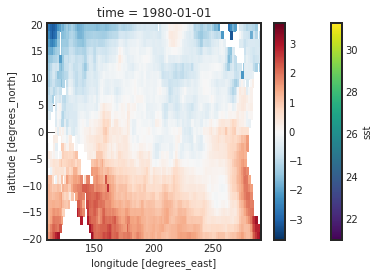

In [37]:
#Select Tropical Pacific SSTs
sst_trop_pac_tmon_merra = sst_tmon_merra.sel(time=slice(time_lo, time_hi), lon=slice(trop_pac_xlo, trop_pac_xhi), lat=slice(trop_pac_ylo, trop_pac_yhi))
sst_trop_pac_tmon_merra[0,:,:].plot()
print(1, sst_trop_pac_tmon_merra[0,25,11])
print(2, sst_trop_pac_tmon_merra[0,25,11].values)
print(3, sst_trop_pac_tmon_merra[0,25,33].values)

#Step 1a)
#Detrend Trop Pac SSTs; only can be done after filling land with 0, and use of scipy
#requires remapping back to xr dataArray and masking of the 0 points (Land)
#Returns the detrended ocean data with the land mask 
aa1 = signal.detrend(sst_trop_pac_tmon_merra.fillna(0.), axis=0, type='linear', bp=0)
print(4, aa1[0,25,11])
print(5, aa1[0,25,33])
print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': sst_trop_pac_tmon_merra.coords['time'], 'lat': sst_trop_pac_tmon_merra.coords['lat'],'lon': sst_trop_pac_tmon_merra.coords['lon']}, dims=('time','lat','lon'))
print(7, aa2[0,25,11].values)
print(8, aa2[0,25,33].values)
print(9, np.count_nonzero(aa2[0,:,:]))

sst_trop_pac_tmon_detrend_merra = aa2.where(aa2 != 0.00000, np.nan)
print(10, sst_trop_pac_tmon_detrend_merra[0,25,11].values)
print(11, sst_trop_pac_tmon_detrend_merra[0,25,33].values)
print(12, np.count_nonzero(sst_trop_pac_tmon_detrend_merra[0,:,:]))
print(13, np.count_nonzero(~np.isnan(sst_trop_pac_tmon_detrend_merra[0,:,:].values)))

sst_trop_pac_tmon_detrend_merra[0,:,:].plot() #2D map
# sst_trop_pac_tmon_detrend_merra.isel(lon=10, lat=5).plot()

# sst_trop_pac_tmon_detrend_merra

In [38]:
#Create SLP Monthly Climatology using data from time_low to time_high
sst_detrend_trop_pac_climatology_merra = sst_trop_pac_tmon_detrend_merra.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
sst_detrend_trop_pac_climatology_merra
print(10, sst_detrend_trop_pac_climatology_merra[0,25,11].values)
print(11, sst_detrend_trop_pac_climatology_merra[0,25,33].values)
print(12, np.count_nonzero(sst_detrend_trop_pac_climatology_merra[0,:,:]))
print(13, np.count_nonzero(~np.isnan(sst_detrend_trop_pac_climatology_merra[0,:,:].values)))

#sst_detrend_trop_pac_climatology_merra[:,90,24].plot()

10 nan
11 1.5532805
12 3240
13 2957


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [39]:
#Step 1)
#Find Tropical SST Anoms using the climatology from time_low to time_hi; using detrended data
sst_anoms_detrend_trop_pac_tmon_merra = sst_trop_pac_tmon_detrend_merra.groupby('time.month') - sst_detrend_trop_pac_climatology_merra
sst_anoms_detrend_trop_pac_tmon_merra

print(10, sst_anoms_detrend_trop_pac_tmon_merra[0,25,11].values)
print(11, sst_anoms_detrend_trop_pac_tmon_merra[0,25,33].values)
print(12, np.count_nonzero(sst_anoms_detrend_trop_pac_tmon_merra[0,:,:]))
print(13, np.count_nonzero(~np.isnan(sst_anoms_detrend_trop_pac_tmon_merra[0,:,:].values)))

10 nan
11 0.6505922
12 3240
13 2957


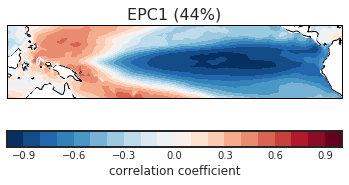

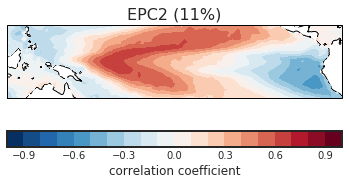

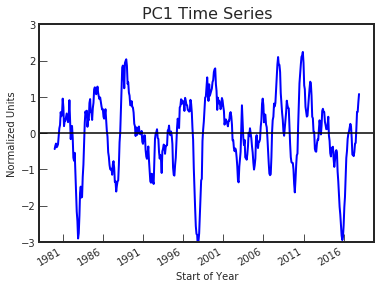

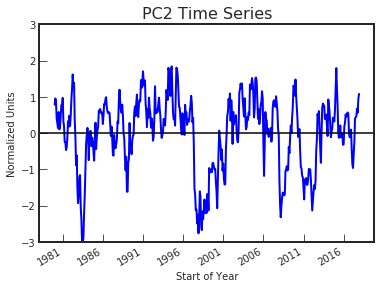

<xarray.DataArray 'variance_fractions' (mode: 2)>
array([0.44442 , 0.109215], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1
Attributes:
    long_name:  variance_fractions


In [40]:
"""
Compute and plot the First Two leading EOFs of Tropical Pacific SST anoms
Recall, sign is arbitrary, will adjust when comparing
Step 2)
"""

#current variable, needs to find and replace 8x
#sst_anoms_detrend_trop_pac_tmon_merra


# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# lat weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst_anoms_detrend_trop_pac_tmon_merra.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_anoms_detrend_trop_pac_tmon_merra, weights=wgts)


# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input Tropical Pac SST anomalies at each grid point, and the
# leading PC time series itself.
eofs_sst_anoms_detrend_trop_pac_tmon_merra = solver.eofsAsCorrelation(neofs=2)
pcs_sst_anoms_detrend_trop_pac_tmon_merra = solver.pcs(npcs=2, pcscaling=1)


# Plot the leading EOF expressed as correlation with Tropical Pac SST Anoms
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
fill = eofs_sst_anoms_detrend_trop_pac_tmon_merra[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EPC1 (44%)', fontsize=16)

# Plot the leading 2nd EOF expressed as correlation with Tropical Pac SST Anoms
plt.figure()
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
fill = eofs_sst_anoms_detrend_trop_pac_tmon_merra[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EPC2 (11%)', fontsize=16)


# Plot the leading PC time series.
plt.figure()
pcs_sst_anoms_detrend_trop_pac_tmon_merra[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)

# Plot the 2nd PC time series.
plt.figure()
pcs_sst_anoms_detrend_trop_pac_tmon_merra[:, 1].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC2 Time Series', fontsize=16)

plt.show()

variance_fractions = solver.varianceFraction(neigs=2)  #number of eigenvalues, ie, number of modes
print(variance_fractions)


# print(10, eofs_sst_anoms_detrend_trop_pac_tmon_merra[0][25,11].values)
# print(11, eofs_sst_anoms_detrend_trop_pac_tmon_merra[0][25,33].values)
# print(12, np.count_nonzero(eofs_sst_anoms_detrend_trop_pac_tmon_merra[0][:,:]))
# print(13, np.count_nonzero(~np.isnan(eofs_sst_anoms_detrend_trop_pac_tmon_merra[0][:,:].values)))

# print(14, eofs_sst_anoms_detrend_trop_pac_tmon_merra[0].coords['lon'].values)
# print(15, sst_anoms_detrend_trop_pac_tmon_merra.coords['lon'].values)


#print(pc1[:, 0].values)

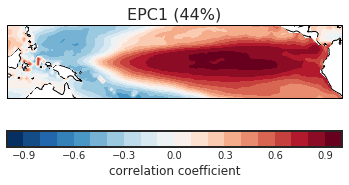

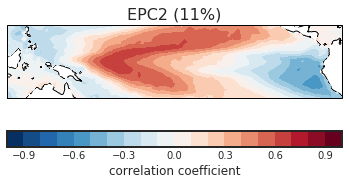

<xarray.DataArray 'variance_fractions' (mode: 2)>
array([0.44442 , 0.109215], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1
Attributes:
    long_name:  variance_fractions


In [41]:
#Plot EPC1 and ECP2 EOFs with correct sign

"""
Compute and plot the First Two leading EOFs of Tropical Pacific SST anoms
Recall, sign is arbitrary, will adjust when comparing
Step 2)
"""

#current variable, needs to find and replace 8x
#sst_anoms_detrend_trop_pac_tmon_merra


# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# lat weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst_anoms_detrend_trop_pac_tmon_merra.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_anoms_detrend_trop_pac_tmon_merra, weights=wgts)


# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input Tropical Pac SST anomalies at each grid point, and the
# leading PC time series itself.
eofs_sst_anoms_detrend_trop_pac_tmon_merra = solver.eofsAsCorrelation(neofs=2)
pcs_sst_anoms_detrend_trop_pac_tmon_merra = solver.pcs(npcs=2, pcscaling=1)


# Plot the leading EOF expressed as correlation with Tropical Pac SST Anoms
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
correct_sign1 = eofs_sst_anoms_detrend_trop_pac_tmon_merra[0]*(-1)
fill = correct_sign1.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EPC1 (44%)', fontsize=16)

# Plot the leading 2nd EOF expressed as correlation with Tropical Pac SST Anoms
plt.figure()
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
fill = eofs_sst_anoms_detrend_trop_pac_tmon_merra[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EPC2 (11%)', fontsize=16)


# # Plot the leading PC time series.
# plt.figure()
# pcs_sst_anoms_detrend_trop_pac_tmon_merra[:, 0].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC1 Time Series', fontsize=16)

# # Plot the 2nd PC time series.
# plt.figure()
# pcs_sst_anoms_detrend_trop_pac_tmon_merra[:, 1].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC2 Time Series', fontsize=16)

#plt.savefig(FIG_PATH+'/fig01_merra_epcs_eof_maps.png',bbox_inches='tight', pad_inches=0.01)

plt.show()

variance_fractions = solver.varianceFraction(neigs=2)  #number of eigenvalues, ie, number of modes
print(variance_fractions)


# print(10, eofs_sst_anoms_detrend_trop_pac_tmon_merra[0][25,11].values)
# print(11, eofs_sst_anoms_detrend_trop_pac_tmon_merra[0][25,33].values)
# print(12, np.count_nonzero(eofs_sst_anoms_detrend_trop_pac_tmon_merra[0][:,:]))
# print(13, np.count_nonzero(~np.isnan(eofs_sst_anoms_detrend_trop_pac_tmon_merra[0][:,:].values)))

# print(14, eofs_sst_anoms_detrend_trop_pac_tmon_merra[0].coords['lon'].values)
# print(15, sst_anoms_detrend_trop_pac_tmon_merra.coords['lon'].values)


#print(pc1[:, 0].values)

**Find Pattern correlation between EOF1 and EOF2 and the monthly tropical SST anomaly 2D maps. This is the EPC1 (Eastern Pacific ENSO Time Series) and EPC2 (Central Pacific ENSO Time Series). Match well with results from Joeng Fig 1, note the different time period**

To create a pattern correlation, it helps to vectorize XY coordinates into a 1D column in both the EOF maps and for every month of the Tropical Pac SST anomalies

In [42]:
#stack EOF1
eof1_stack_sst_anoms_detrend_trop_pac_tmon_merra = eofs_sst_anoms_detrend_trop_pac_tmon_merra[0].stack(xy=('lat', 'lon'))
print(eof1_stack_sst_anoms_detrend_trop_pac_tmon_merra.shape)
#drop nans for correlation
eof1_stack_sst_anoms_detrend_trop_pac_tmon_merra = eof1_stack_sst_anoms_detrend_trop_pac_tmon_merra[~np.isnan(eof1_stack_sst_anoms_detrend_trop_pac_tmon_merra)].values
#column length of stacked XY coordinate EOF1 values:
print(eof1_stack_sst_anoms_detrend_trop_pac_tmon_merra.shape)


(3240,)
(2957,)


In [43]:
#stack EOF2
eof2_stack_sst_anoms_detrend_trop_pac_tmon_merra = eofs_sst_anoms_detrend_trop_pac_tmon_merra[1].stack(xy=('lat', 'lon'))
print(eof2_stack_sst_anoms_detrend_trop_pac_tmon_merra.shape)
#drop nans for correlation
eof2_stack_sst_anoms_detrend_trop_pac_tmon_merra = eof2_stack_sst_anoms_detrend_trop_pac_tmon_merra[~np.isnan(eof2_stack_sst_anoms_detrend_trop_pac_tmon_merra)].values
# column length of stacked XY coordinate EOF2 values:
print(eof2_stack_sst_anoms_detrend_trop_pac_tmon_merra.shape)


(3240,)
(2957,)


In [44]:
#Need to make nans in the SST anoms where the random nans in the EOFs are before stacking SST anoms
sst_anoms_detrend_trop_pac_tmon_add_nans_merra = sst_anoms_detrend_trop_pac_tmon_merra.where(~np.isnan(eofs_sst_anoms_detrend_trop_pac_tmon_merra[1]))

#stack SST anoms
stack_of_sst_anoms_detrend_trop_pac_tmon_merra = sst_anoms_detrend_trop_pac_tmon_add_nans_merra.stack(xy=('lat', 'lon')).values
print(stack_of_sst_anoms_detrend_trop_pac_tmon_merra.shape)
print(np.count_nonzero(~np.isnan(stack_of_sst_anoms_detrend_trop_pac_tmon_merra[0,:])))

#drop nans for correlation
stack_of_sst_anoms_detrend_trop_pac_tmon_merra = stack_of_sst_anoms_detrend_trop_pac_tmon_merra[~np.isnan(stack_of_sst_anoms_detrend_trop_pac_tmon_merra)]
print(stack_of_sst_anoms_detrend_trop_pac_tmon_merra.shape)

stack_of_sst_anoms_detrend_trop_pac_tmon_merra = np.reshape(stack_of_sst_anoms_detrend_trop_pac_tmon_merra, (len(pcs_sst_anoms_detrend_trop_pac_tmon_merra[:, 0]), len(eof1_stack_sst_anoms_detrend_trop_pac_tmon_merra)))
print(stack_of_sst_anoms_detrend_trop_pac_tmon_merra.shape)



(456, 3240)
2957
(1348392,)
(456, 2957)


In [45]:
#Step 3)
#Find the pattern correlation btw EOF1 2D map and Tropical SST Anom 2D Maps 
#for each month


x = eof1_stack_sst_anoms_detrend_trop_pac_tmon_merra
y = stack_of_sst_anoms_detrend_trop_pac_tmon_merra
print(x.shape, y.shape)


#calculate the correlation of every row in a 2D array to a 1D array of the same length
#https://www.quora.com/How-do-I-calculate-the-correlation-of-every-row-in-a-2D-array-to-a-1D-array-of-the-same-length
#x is 1D, m
#y is 2D, nXm with second dimension equal in length to length of x, m


x_bar = np.mean(x)
x_intermediate = x - x_bar

y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
y_intermediate = y - y_bar

numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)

x_sq = np.sum(np.square(x_intermediate))

y_sqs = np.sum(np.square(y_intermediate), axis=1)

denominators = np.sqrt(x_sq * y_sqs) # scalar times vector

pearsons = (numerators/denominators) # numerators is shape (100,) and denominators is shape (100,)

eof1_and_sst_pattern_corr_coef_merra = pearsons
print(eof1_and_sst_pattern_corr_coef_merra.shape)

(2957,) (456, 2957)
(456,)


In [46]:
#Find the pattern correlation btw EOF2 2D map and Tropical SST Anom 2D Maps 
#for each month


x = eof2_stack_sst_anoms_detrend_trop_pac_tmon_merra
y = stack_of_sst_anoms_detrend_trop_pac_tmon_merra
print(x.shape, y.shape)


#calculate the correlation of every row in a 2D array to a 1D array of the same length
#https://www.quora.com/How-do-I-calculate-the-correlation-of-every-row-in-a-2D-array-to-a-1D-array-of-the-same-length
#x is 1D, m
#y is 2D, nXm with second dimension equal in length to length of x, m


x_bar = np.mean(x)
x_intermediate = x - x_bar

y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
y_intermediate = y - y_bar

numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)

x_sq = np.sum(np.square(x_intermediate))

y_sqs = np.sum(np.square(y_intermediate), axis=1)

denominators = np.sqrt(x_sq * y_sqs) # scalar times vector

pearsons = (numerators/denominators) # numerators is shape (100,) and denominators is shape (100,)

eof2_and_sst_pattern_corr_coef_merra = pearsons
print(eof2_and_sst_pattern_corr_coef_merra.shape)

(2957,) (456, 2957)
(456,)


In [47]:
#Step 4, normalize data to have mean of 0 and std of 1.
norm_eof1_and_sst_pattern_corr_coef_merra = (eof1_and_sst_pattern_corr_coef_merra - np.mean(eof1_and_sst_pattern_corr_coef_merra))/np.std(eof1_and_sst_pattern_corr_coef_merra)

norm_eof2_and_sst_pattern_corr_coef_merra = (eof2_and_sst_pattern_corr_coef_merra - np.mean(eof2_and_sst_pattern_corr_coef_merra))/np.std(eof2_and_sst_pattern_corr_coef_merra)


In [48]:
#Finalize ENSO indices and put into pandas dataframE
#NOTE, EPC1 IS MULTIPLIED BY -1 TO HAVE POSITIVE CENTER FOR CENTRAL PACIFIC
df_EPC1_merra = pd.DataFrame(norm_eof1_and_sst_pattern_corr_coef_merra)*(-1)
df_EPC1_merra.columns = ['EPC1']
#df_EPC1_merra

df_EPC2_merra = pd.DataFrame(norm_eof2_and_sst_pattern_corr_coef_merra)
df_EPC2_merra.columns = ['EPC2']
#df_EPC2_merra

df_time_merra = pd.DataFrame(sst_anoms_detrend_trop_pac_tmon_merra.coords['time'].values)
df_time_merra.columns = ['time']
#df_time_merra

enso_indices_merra = pd.concat([df_time_merra, df_EPC1_merra, df_EPC2_merra], axis=1)

enso_indices_merra.to_pickle(PICKLE_PATH+'/merra_epcs_tmon.pkl')

enso_indices_merra.head(n=5)

#Note, I am not smoothing the time series by 5 months bc I end up looking at seasonal means which is essentially
#a smoothing of three months

,time,EPC1,EPC2
0,1980-01-01,0.168157,1.045394
1,1980-02-01,-0.070377,1.252434
2,1980-03-01,-0.284891,1.106109
3,1980-04-01,0.182450,0.356550
4,1980-05-01,0.121061,0.144655


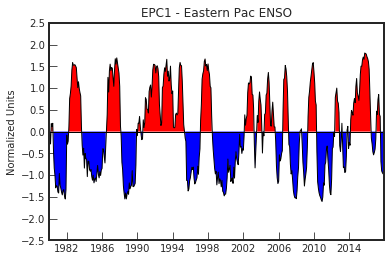

In [49]:
fig, ax1 = plt.subplots()


sns.set_style('white')
sns.set_style('ticks',
              {'xtick.major.size':8, 'ytick.major.size':8,
               'xtick.direction': 'in', 'ytick.direction': 'in',
               'axes.linewidth':2 })
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 3),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}



x = enso_indices_merra.time.values
y1 = enso_indices_merra.EPC1.values  ###Check to see if I need to Multiply by -1 to get sign correct###

#ax1.set_xlabel('Day')
#ax1.set_ylabel('Mean SLP (hPa)')
ax1.set_title('EPC1 - Eastern Pac ENSO')
ax1.set_ylim(-2.5,2.5)
ax1.yaxis.set_ticks(np.arange(-2.5, 3, .5))
ax1.set_ylabel('Normalized Units')
ax1.set_xlim(enso_indices_merra.time.values[0],enso_indices_merra.time.values[len(enso_indices_merra.time)-1])
#ax1.xaxis.set_ticks(np.arange(enso_indices_merra.time.values[36], result.time.values[len(enso_indices_merra.time)-1],5))
ax1.plot(x, y1, color='k',linewidth=1.0)
ax1.fill_between(x, 0, y1, where=y1 > 0, facecolor='red')
ax1.fill_between(x, 0, y1, where=y1 < 0, facecolor='blue')
ax1.axhline(y=0, linewidth=1.0, color='k')
#ax1.axhline(y=0.79, linewidth=1.0) #Sig as defined in Joeng 2017
#ax1.axhline(y=-0.79, linewidth=1.0) #Sig as defined in Joeng 2017

plt.show()

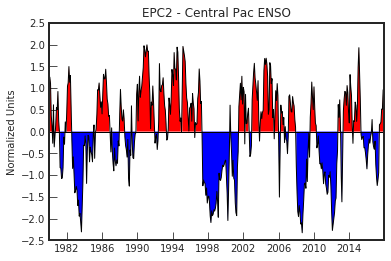

In [50]:
fig, ax1 = plt.subplots()


sns.set_style('white')
sns.set_style('ticks',
              {'xtick.major.size':8, 'ytick.major.size':8,
               'xtick.direction': 'in', 'ytick.direction': 'in',
               'axes.linewidth':2 })
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 3),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}



x = enso_indices_merra.time.values
y1 = enso_indices_merra.EPC2.values 

#ax1.set_xlabel('Day')
#ax1.set_ylabel('Mean SLP (hPa)')
ax1.set_title('EPC2 - Central Pac ENSO')
ax1.set_ylim(-2.5,2.5)
ax1.yaxis.set_ticks(np.arange(-2.5, 3, .5))
ax1.set_ylabel('Normalized Units')
ax1.set_xlim(enso_indices_merra.time.values[0],enso_indices_merra.time.values[len(enso_indices_merra.time)-1])
#ax1.xaxis.set_ticks(np.arange(enso_indices_merra.time.values[36], enso_indices_merra.time.values[len(enso_indices_merra.time)-1],5))
ax1.plot(x, y1, color='k',linewidth=1.0)
ax1.fill_between(x, 0, y1, where=y1 > 0, facecolor='red')
ax1.fill_between(x, 0, y1, where=y1 < 0, facecolor='blue')
ax1.axhline(y=0, linewidth=1.0, color='k')
#ax1.axhline(y=0.79, linewidth=1.0) #Sig as defined in Joeng 2017
#ax1.axhline(y=-0.79, linewidth=1.0) #Sig as defined in Joeng 2017

plt.show()

**Calculate SAM and PSA1 and PSA2 indices via first 3 EOFs of Southern Hemi SLP Anoms** <br>
http://research.jisao.washington.edu/data/aao/slp/ -for SAM<br>
Also see Yu et al 2011 for definition of SAM (AAO) and PSA1 and PSA2
<br> <br>
The time series is calculated as follows:<br>
1a) Detrend the slp in the Southern Hemisphere region (South of 20S)<br>
1) SLP Anomalies are calculated for each calendar month with respect to the 00020101-00491231.  <br>
2) Each grid box is area weighted by the square root of the cosine of the central latitude.<br>
3) The covariance matrix of the area-weighted data is calculated for the grid boxes south of 20S, and the principal component (PC, timeseries ) calculated for that matrix. The first EOF is SAM, the second is PSA1 (Pacific-South American teleconnection, and third is PSA2 - see Yu et al 2011<br>
4) The mean and standard deviation are adjusted to be 0 and 1, respectively, for the period 00020101-00491231, all calendar months combined. This is a standard way to perform this calculation.<br>
**Not doing the rest:**<br>
4) The PC is correlated with global SLP anomalies, and that correlation map projected onto the data, including area weighting, to produce a time series for SAM for the entire record. (Not sure how he did this) <br>
5) The mean and standard deviation are adjusted to be 0 and 1, respectively, for the period 00020101-00491231, all calendar months combined. This is a standard way to perform this calculation.<br>

In [51]:
#params to be set
shem_yhi = -90 #Had to reverse hi and lo lat values for ERA & MERRA
shem_ylo = -20  #Had to reverse hi and lo lat values for ERA & MERRA


In [52]:
slp_shem_tmon_merra = slp_tmon_merra.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))
# slp_shem_tmon_merra[0].plot()

In [53]:
#Step 1a)
#Detrend Southern Hem SLPs; use of scipy
#requires remapping back to xr dataArray 
#Returns the detrended slp data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(slp_shem_tmon_merra, axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': slp_shem_tmon_merra.coords['time'], 'lat': slp_shem_tmon_merra.coords['lat'],'lon': slp_shem_tmon_merra.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

slp_shem_tmon_detrend_merra = aa2

# slp_shem_tmon_detrend_merra[0,:,:].plot() #2D map

In [54]:
#Create SLP Monthly Climatology from detrended data using data from time_lo to time_hi
slp_detrend_shem_climatology_merra = slp_shem_tmon_detrend_merra.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# slp_detrend_shem_climatology_merra

#slp_detrend_shem_climatology_merra[:,90,24].plot()

In [55]:
#Step 1)
#Find Southern Hemisphere SLP Anoms using the climatology from time_lo to time_hi
slp_anoms_shem_tmon_detrend_merra = slp_shem_tmon_detrend_merra.groupby('time.month') - slp_detrend_shem_climatology_merra
#slp_anoms_shem_tmon_detrend_merra

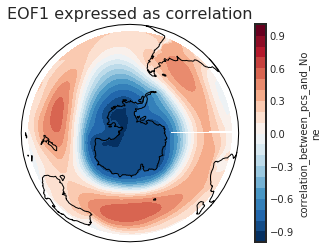

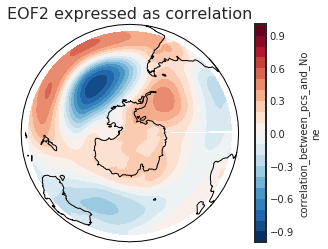

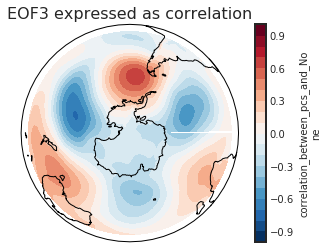

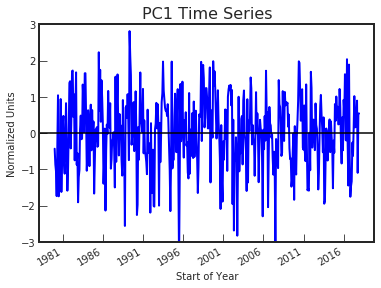

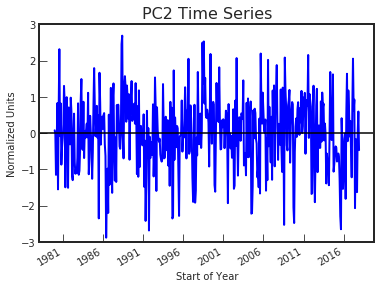

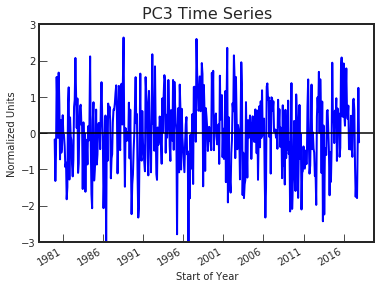

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.269722, 0.110213, 0.093898], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


In [56]:
"""
Compute and plot the 3 leading EOF of detrended SLP anomalies south of 20S

Includes Step 2), 3)

From Marshall and Thompson 2016, look at Fig 3, from this and my work with the PSA1, PSA2, SAM, 
correlations with T2M, PSA2 needs to have sign changes in order to get proper correlation with T2M.
"""

#Step 2)
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)).coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)), weights=wgts)

#Step 3)
# Retrieve the First Three EOF, expressed as the correlation between the leading
# PC time series and the input SLP anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=1)


# Plot the leading EOF expressed as correlation with SLP S of 20S
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF1 expressed as correlation', fontsize=16)


# Plot the 2nd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF2 expressed as correlation', fontsize=16)

# Plot the 3rd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF3 expressed as correlation', fontsize=16)


# Plot the leading PC time series.
plt.figure()
pc1[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)


# Plot the 2nd PC time series.
plt.figure()
pc1[:, 1].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC2 Time Series', fontsize=16)

# Plot the 2nd PC time series.
plt.figure()
pc1[:, 2].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC3 Time Series', fontsize=16)


plt.show()

variance_fractions = solver.varianceFraction(neigs=3)  #number of eigenvalues, ie, number of modes
print(variance_fractions)

#print(pc1[:, 0].values)

In [57]:
#Step 4, normalize to 0 mean and 1 STD (the eof method actually already did this, so not much change in the time series)
SAM_tmon_merra = pc1[:, 0]
# print(SAM_tmon_merra.mean(),SAM_tmon_merra.std())
norm_SAM_tmon_merra = (SAM_tmon_merra - SAM_tmon_merra.mean())/SAM_tmon_merra.std()
# print(norm_SAM_tmon_merra.mean(),norm_SAM_tmon_merra.std())

PSA1_tmon_merra = pc1[:, 1]
norm_PSA1_tmon_merra = (PSA1_tmon_merra - PSA1_tmon_merra.mean())/PSA1_tmon_merra.std()
# print(norm_PSA1_tmon_merra.mean(),norm_PSA1_tmon_merra.std())

PSA2_tmon_merra = pc1[:, 2]
norm_PSA2_tmon_merra = (PSA2_tmon_merra - PSA2_tmon_merra.mean())/PSA2_tmon_merra.std()
# print(norm_PSA2_tmon_merra.mean(),norm_PSA2_tmon_merra.std())



In [58]:
#For copying to Excel: C:\Users\Paul\Desktop\Tabor\SAM_Trials_with_EOF_from_WASH_U_Definition.xlsx
series = norm_SAM_tmon_merra.to_series()

pd_series = pd.Series.to_frame(series)

# with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#     print(pd_series)

In [59]:
#SAM, PSA1, PSA2 indices as pandas dataframe
#NOTE, negative center over AA (eof1), positive center ASL (eof2), negative center AP (eof3)
df_SAM_merra = pd.DataFrame(norm_SAM_tmon_merra.values)
df_SAM_merra.columns = ['SAM']
#df_SAM_merra

df_PSA1_merra = pd.DataFrame(norm_PSA1_tmon_merra.values)*(-1)
df_PSA1_merra.columns = ['PSA1']
#df_PSA1_merra

df_PSA2_merra = pd.DataFrame(norm_PSA2_tmon_merra.values)*(-1)
df_PSA2_merra.columns = ['PSA2']
#df_SAM_merra

df_time_merra = pd.DataFrame(norm_SAM_tmon_merra.coords['time'].values)
df_time_merra.columns = ['time']
#df_time_merra

SAM_PSAs_indices_merra = pd.concat([df_time_merra, df_SAM_merra, df_PSA1_merra, df_PSA2_merra], axis=1)

SAM_PSAs_indices_merra.to_pickle(PICKLE_PATH+'/merra_sam_psas_tmon.pkl')

SAM_PSAs_indices_merra.head(n=5)
#SAM_PSAs_indices_merra.to_csv('Monthly_merra_SAM_PSAs.csv')

,time,SAM,PSA1,PSA2
0,1980-01-01,-0.429369,-0.078547,0.174077
1,1980-02-01,-0.866544,0.031309,1.320172
2,1980-03-01,-1.050691,1.151231,0.593894
3,1980-04-01,-1.737197,0.386887,-1.552102
4,1980-05-01,-0.420486,-0.829418,-0.691180


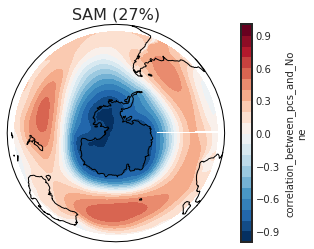

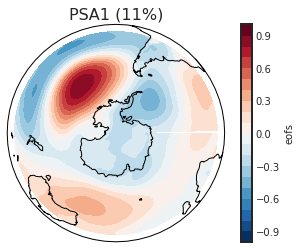

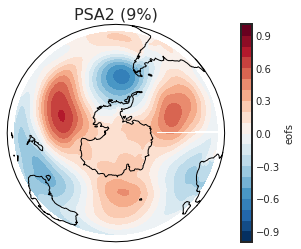

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.269722, 0.110213, 0.093898], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


In [60]:
# PLOTTING SAM and PSA1-2 EOFs with correct sign (multiplying PSA2 by -1)
"""
Compute and plot the 3 leading EOF of detrended SLP anomalies south of 20S

Includes Step 2), 3)
"""

#Step 2)
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)).coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)), weights=wgts)

#Step 3)
# Retrieve the First Three EOF, expressed as the correlation between the leading
# PC time series and the input SLP anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=1)


# Plot the leading EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('SAM (27%)', fontsize=16)


# Plot the 2nd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
psa1_sign = eof1[1]*(-1)
psa1_sign.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA1 (11%)', fontsize=16)

# Plot the 3rd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
psa2_sign = eof1[2]*(-1)
psa2_sign.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA2 (9%)', fontsize=16)


# # Plot the leading PC time series.
# plt.figure()
# pc1[:, 0].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC1 Time Series', fontsize=16)


# # Plot the 2nd PC time series.
# plt.figure()
# pc1[:, 1].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC2 Time Series', fontsize=16)

# # Plot the 2nd PC time series.
# plt.figure()
# pc1[:, 2].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC3 Time Series', fontsize=16)

#plt.savefig(FIG_PATH+'/fig02_merra_sam_and_psas_eof_maps.png',bbox_inches='tight', pad_inches=0.01)

plt.show()

variance_fractions = solver.varianceFraction(neigs=3)  #number of eigenvalues, ie, number of modes
print(variance_fractions)

#print(pc1[:, 0].values)

**Now making regression and correlation of SLP anomalies onto and with SAM. Like figures from http://research.jisao.washington.edu/data/aao/slp/ **

**Regression for 2D domain:**

In [61]:
#Regression Coefficient
#Code by Brewster

# Stack lat, lon into single `xy` so we only have two dims instead of three.
slp_anoms_shem_tmon_detrend_stack_merra = slp_anoms_shem_tmon_detrend_merra.stack(xy=('lat', 'lon'))
print(slp_anoms_shem_tmon_detrend_stack_merra.shape)

n_time = len(slp_anoms_shem_tmon_detrend_merra.time)
ts = SAM_PSAs_indices_merra.SAM.values

# There are a couple ways to do the regression part. This is more of a bare metal linear algebra approach.
# Also see `scipy.stats.linregress` if you need something more higher 
# level/convenient. Should be faster than statsmodels.

# Build "coef matrix"
a = np.array([ts.squeeze(), np.ones(n_time)])
print(a.shape)

# I'd keep slp as the dependent variable
betas = np.linalg.lstsq(a.T, slp_anoms_shem_tmon_detrend_stack_merra.values)[0]

# This is what we want:
slope, intercept = betas

# Add our slope data to the stacked Dataset. Telling it that it's one dimension
#  is `xy` (i.e. our stacked latlon).
slp_anoms_shem_tmon_detrend_stack_merra['slope'] = (('xy'), slope)

 # Unstack `xy` back into lat, lon. Make sure girls are watching so someone can 
 # be really impressed with what you're doing.
sam_and_slp_pattern_regr_coef_merra = slp_anoms_shem_tmon_detrend_stack_merra.unstack('xy')[0]

# Plot for sanity check.
#sam_and_slp_pattern_regr_coef_merra[:,:].slope.plot()
#plt.show()  

# Values agree with the above point by point selection
# print(super_cool_dataset[0,110,160].slope)
# print(super_cool_dataset[0,87,116].slope)

(456, 11280)
(2, 456)


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [62]:
# #https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import AxesGrid

# def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
#     '''
#     Function to offset the "center" of a colormap. Useful for
#     data with a negative min and positive max and you want the
#     middle of the colormap's dynamic range to be at zero.

#     Input
#     -----
#       cmap : The matplotlib colormap to be altered
#       start : Offset from lowest point in the colormap's range.
#           Defaults to 0.0 (no lower offset). Should be between
#           0.0 and `midpoint`.
#       midpoint : The new center of the colormap. Defaults to 
#           0.5 (no shift). Should be between 0.0 and 1.0. In
#           general, this should be  1 - vmax / (vmax + abs(vmin))
#           For example if your data range from -15.0 to +5.0 and
#           you want the center of the colormap at 0.0, `midpoint`
#           should be set to  1 - 5/(5 + 15)) or 0.75
#       stop : Offset from highest point in the colormap's range.
#           Defaults to 1.0 (no upper offset). Should be between
#           `midpoint` and 1.0.
#     '''
#     cdict = {
#         'red': [],
#         'green': [],
#         'blue': [],
#         'alpha': []
#     }

#     # regular index to compute the colors

In [63]:
# Plot the leading EOF expressed as correlation with SLP S of 20S
# fig, ax = plt.subplots(figsize=(20, 10))



# clevs = np.linspace(-7, 2, 10)
# #clevels = [-7,-6,-5,-4,-3,-2,-1,0,1,2]

# #to create a non-monotonic colorbar that is still centered on zero
# #norm = colors.BoundaryNorm(boundaries=clevels, ncolors=256)

# proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
# ax = plt.axes(projection=proj)
# ax.coastlines()
# ax.set_global()
# ppp = sam_and_slp_pattern_regr_coef_era.slope
# ppp.plot.contourf(ax=ax, levels=clevs,  cmap=plt.cm.RdBu_r,
#                          transform=ccrs.PlateCarree(), add_colorbar=True, extend='both')
# ax.set_title('Regression of SLP Anoms onto SAM (hPa/std of index)', fontsize=16)

In [64]:
# #SLP anomaly correlations with the SAM. The SAM explains several percent of the variance in the tropics.
# #Agrees with figure from 

# x = SAM_PSAs_indices_era.SAM.values
# y = slp_anoms_shem_tmon_detrend_stack_era.T.values
# print(x.shape, y.shape)


# #calculate the correlation of every row in a 2D array to a 1D array of the same length
# #https://www.quora.com/How-do-I-calculate-the-correlation-of-every-row-in-a-2D-array-to-a-1D-array-of-the-same-length
# #x is 1D, m
# #y is 2D, nXm with second dimension equal in length to length of x, m


# x_bar = np.mean(x)
# x_intermediate = x - x_bar

# y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
# y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
# y_intermediate = y - y_bar

# numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)

# x_sq = np.sum(np.square(x_intermediate))

# y_sqs = np.sum(np.square(y_intermediate), axis=1)

# denominators = np.sqrt(x_sq * y_sqs) # scalar times vector

# pearsons = (numerators/denominators) # numerators is shape (m,) and denominators is shape (m,)

# # Add our pearson corr coef data to the stacked Dataset. Telling it that it's one dimension
# #  is `xy` (i.e. our stacked latlon).
# slp_anoms_shem_tmon_detrend_stack_era['pearsons'] = (('xy'), pearsons)

# # Unstack `xy` back into lat, lon. Make sure girls are watching so someone can 
# # be really impressed with what you're doing.
# sam_and_slp_pattern_corr_coef_era = slp_anoms_shem_tmon_detrend_stack_era.unstack('xy')[0]

# #plot, looks good compared to results online/published
# #sam_and_slp_pattern_corr_coef_era[:,:].pearsons.plot()

In [65]:
# # Plot the leading EOF expressed as correlation with Tropical Pac SST Anoms
# fig, ax = plt.subplots(figsize=(20, 10))

# clevs = np.linspace(-1, 1, 21)
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
# fill = sam_and_slp_pattern_corr_coef_era[:,:].pearsons.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
#                              add_colorbar=False, transform=ccrs.PlateCarree())
# ax.add_feature(cfeature.COASTLINE, edgecolor='k')
# cb = plt.colorbar(fill, orientation='horizontal')
# cb.set_label('correlation coefficient', fontsize=16)
# ax.set_title('SLP Anoms Correlation with SAM', fontsize=16)

**Gather the Seasonal Mean for each year for the EPC1, EPC2, SAM, PSA1, PSA2 indices**<br>
**Calculate correlations between these indices looking at the seasonal means**<br>
Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [66]:
#Make time the index column so that we can use resample for seasonal means
enso_indices_merra.time = pd.to_datetime(enso_indices_merra.time)
enso_indices_merra.set_index('time', inplace=True)
#enso_indices_merra

#DataFrame of ENSO Indices as Seasonal Means, from 1982 MAM through 2014 SON
enso_seas_mean_indices_merra = enso_indices_merra[2:(len(enso_indices_merra['EPC1'])-1)].resample('3MS', closed='left'  ).mean()
#enso_seas_mean_indices_merra

enso_seas_mean_indices_merra['Seas_Index'] = enso_seas_mean_indices_merra.index.astype(str).str[5:7]

enso_seas_mean_indices_merra.to_pickle(PICKLE_PATH+'/merra_epcs_seas.pkl')

enso_seas_mean_indices_merra.head(n=5)

,EPC1,EPC2,Seas_Index
time,,,
1980-03-01,0.006206,0.535771,03
1980-06-01,-0.357774,-0.001382,06
1980-09-01,-1.181633,0.195323,09
1980-12-01,-1.354119,0.556736,12
1981-03-01,-1.164872,-0.550217,03


In [67]:
#Make time the index column so that we can use resample for seasonal means
SAM_PSAs_indices_merra.time = pd.to_datetime(SAM_PSAs_indices_merra.time)
SAM_PSAs_indices_merra.set_index('time', inplace=True)
#SAM_PSAs_indices_merra

#DataFrame of SAM and PSAs indices as Seasonal Means, from 0002 MAM through 0049 SON
SAM_PSAs_seas_mean_index_merra = SAM_PSAs_indices_merra[2:(len(SAM_PSAs_indices_merra['SAM'])-1)].resample('3MS', closed='left'  ).mean()
#SAM_PSAs_seas_mean_index_merra

#Add Seasonal index to use for groupby or sort
SAM_PSAs_seas_mean_index_merra['Seas_Index'] = SAM_PSAs_seas_mean_index_merra.index.astype(str).str[5:7]

SAM_PSAs_seas_mean_index_merra.to_pickle(PICKLE_PATH+'/merra_sam_psas_seas.pkl')

SAM_PSAs_seas_mean_index_merra.head(n=5)

,SAM,PSA1,PSA2,Seas_Index
time,,,,
1980-03-01,-1.069458,0.236233,-0.549796,03
1980-06-01,-0.394065,-0.462641,-0.779531,06
1980-09-01,-0.591505,0.042762,0.298846,09
1980-12-01,0.036406,0.092091,-0.021163,12
1981-03-01,-0.690965,-0.213709,0.451755,03


In [68]:
#SAM_PSAs_indices_merra['SAM']

In [69]:
#SAM_PSAs_seas_mean_index_merra.SAM.where(enso_seas_mean_indices_merra.Seas_Index == '09').dropna().plot()

In [70]:
# aaa = SAM_PSAs_seas_mean_index_merra.PSA1.where(enso_seas_mean_indices_merra.Seas_Index == '09').dropna()*(-1)
# aaa.plot()


**Gather the Annual Mean for the EPC1, EPC2, SAM, PSA1, PSA2 indices**<br>
**For Calculating correlations between these indices looking at the annual means**<br>
Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [71]:

#DataFrame of ENSO Indices as annual Means, from 0002 Jan through 0049 Dec
enso_ann_mean_indices_merra = enso_indices_merra[:].resample('AS', closed='left'  ).mean()

enso_ann_mean_indices_merra.to_pickle(PICKLE_PATH+'/merra_epcs_ann_mean.pkl')

enso_ann_mean_indices_merra.head(n=5)


,EPC1,EPC2
time,,
1980-01-01,-0.480026,0.415913
1981-01-01,-1.350530,-0.304684
1982-01-01,0.817853,0.251650
1983-01-01,0.664396,-1.555059
1984-01-01,-0.818031,-0.440729


In [72]:
#DataFrame of SAM and PSAs indices as annual Means, from 0002 Jan through 0049 Dec
SAM_PSAs_ann_mean_index_merra = SAM_PSAs_indices_merra[:].resample('AS', closed='left'  ).mean()

SAM_PSAs_ann_mean_index_merra.to_pickle(PICKLE_PATH+'/merra_sam_psas_ann_mean.pkl')


SAM_PSAs_ann_mean_index_merra.head(n=5)
# SAM_PSAs_ann_mean_index_merra.SAM.plot()

,SAM,PSA1,PSA2
time,,,
1980-01-01,-0.668621,-0.017543,-0.104431
1981-01-01,-0.055415,-0.121323,0.318200
1982-01-01,0.274640,0.355236,-0.144263
1983-01-01,0.342535,0.077386,0.168693
1984-01-01,-0.137652,-0.036246,0.245102


**Gather the 12-month running Mean for the EPC1, EPC2, SAM, PSA1, PSA2 indices**<br>
**Calculate correlations between these indices looking at the annual means**<br>
Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [73]:

#DataFrame of ENSO Indices as 12 month rolling means (centered), from 0002 Jan through 0049 Dec
enso_12roll_mean_indices_merra = enso_indices_merra[:].rolling(12, min_periods=12, center=True).mean()

enso_12roll_mean_indices_merra.to_pickle(PICKLE_PATH+'/merra_epcs_12roll_mean.pkl')

enso_12roll_mean_indices_merra.head(n=10)


,EPC1,EPC2
time,,
1980-01-01,NaN,NaN
1980-02-01,NaN,NaN
1980-03-01,NaN,NaN
1980-04-01,NaN,NaN
1980-05-01,NaN,NaN
1980-06-01,NaN,NaN
1980-07-01,-0.480026,0.415913
1980-08-01,-0.609907,0.405625
1980-09-01,-0.721830,0.321612


In [74]:

#DataFrame of SAM and PSAs indices as 12 month rolling means (centered), from 0002 Jan through 0049 Dec
SAM_PSAs_12roll_mean_index_merra = SAM_PSAs_indices_merra[:].rolling(12, min_periods=12, center=True).mean()

SAM_PSAs_12roll_mean_index_merra.to_pickle(PICKLE_PATH+'/merra_sam_psas_12roll_mean.pkl')

SAM_PSAs_12roll_mean_index_merra.head(n=10)


,SAM,PSA1,PSA2
time,,,
1980-01-01,NaN,NaN,NaN
1980-02-01,NaN,NaN,NaN
1980-03-01,NaN,NaN,NaN
1980-04-01,NaN,NaN,NaN
1980-05-01,NaN,NaN,NaN
1980-06-01,NaN,NaN,NaN
1980-07-01,-0.668621,-0.017543,-0.104431
1980-08-01,-0.616573,-0.000642,-0.160243
1980-09-01,-0.504656,-0.022889,-0.262911


**Gather the 6-month running Mean for the EPC1, EPC2, SAM, PSA1, PSA2 indices**<br>
**Calculate correlations between these indices looking at the annual means**<br>
Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [75]:

#DataFrame of ENSO Indices as 6 month rolling means (centered), from 0002 Jan through 0049 Dec
enso_6roll_mean_indices_merra = enso_indices_merra[:].rolling(6, min_periods=6, center=True).mean()

enso_6roll_mean_indices_merra.to_pickle(PICKLE_PATH+'/merra_epcs_6roll_mean.pkl')

enso_6roll_mean_indices_merra.head(n=5)


,EPC1,EPC2
time,,
1980-01-01,NaN,NaN
1980-02-01,NaN,NaN
1980-03-01,NaN,NaN
1980-04-01,0.051146,0.606147
1980-05-01,-0.047394,0.534565


In [76]:

#DataFrame of SAM and PSAs indices as 6 month rolling means (centered), from 0002 Jan through 0049 Dec
SAM_PSAs_6roll_mean_index_merra = SAM_PSAs_indices_merra[:].rolling(6, min_periods=6, center=True).mean()

SAM_PSAs_6roll_mean_index_merra.to_pickle(PICKLE_PATH+'/merra_sam_psas_6roll_mean.pkl')

SAM_PSAs_6roll_mean_index_merra.head(n=5)


,SAM,PSA1,PSA2
time,,,
1980-01-01,NaN,NaN,NaN
1980-02-01,NaN,NaN,NaN
1980-03-01,NaN,NaN,NaN
1980-04-01,-0.576348,0.368920,-0.004137
1980-05-01,-0.795468,0.278557,-0.311970


**Gather the 3-month running Mean for the EPC1, EPC2, SAM, PSA1, PSA2 indices**<br>
**Calculate correlations between these indices looking at the annual means**<br>
Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [77]:

#DataFrame of ENSO Indices as 3 month rolling means (centered), from 0002 Jan through 0049 Dec
enso_3roll_mean_indices_merra = enso_indices_merra[:].rolling(3, min_periods=3, center=True).mean()

enso_3roll_mean_indices_merra.to_pickle(PICKLE_PATH+'/merra_epcs_3roll_mean.pkl')

enso_3roll_mean_indices_merra.head(n=5)


,EPC1,EPC2
time,,
1980-01-01,NaN,NaN
1980-02-01,-0.062370,1.134646
1980-03-01,-0.057606,0.905031
1980-04-01,0.006206,0.535771
1980-05-01,0.164661,0.077648


In [78]:

#DataFrame of SAM and PSAs indices as 3 month rolling means (centered), from 0002 Jan through 0049 Dec
SAM_PSAs_3roll_mean_index_merra = SAM_PSAs_indices_merra[:].rolling(3, min_periods=3, center=True).mean()

SAM_PSAs_3roll_mean_index_merra.to_pickle(PICKLE_PATH+'/merra_sam_psas_3roll_mean.pkl')

SAM_PSAs_3roll_mean_index_merra.head(n=5)


,SAM,PSA1,PSA2
time,,,
1980-01-01,NaN,NaN,NaN
1980-02-01,-0.782201,0.367998,0.696047
1980-03-01,-1.218144,0.523142,0.120654
1980-04-01,-1.069458,0.236233,-0.549796
1980-05-01,-0.370495,0.369842,-0.704321


**Gather the 2-7-yr band pass filter for the EPC1, EPC2, SAM, PSA1, PSA2 indices**<br>

Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [79]:
# def filt_but_low(tab,cutoff,samp,btype='lowpass',N=2):
#    """Butterworth filter with
#       tab : array to be filtered (assume that first dimension is time
#       N : filter order (polynom)
#       cutoff : cutoff period in units of basic period (days, months years etc.)
#       samp : sampling rate in same units
#    """
#    # First, design the Butterworth filter
#    N  = 2
#    Wn = samp/cutoff
#    B, A = signal.butter(N, Wn,btype=btype, output='ba')
#    # Second: padding on left and right
#    L  = int(np.round(cutoff/samp))    # determine length of padding
#    M  = tab.shape[0]
#    pl = np.flipud(tab[1:L+1,...])  # padding on left
#    pr = np.flipud(tab[M-L-1:M-1,...])  # padding on right
#    tab_pad = np.zeros(tab.shape[1:])*np.ones((tab.shape[0]+2*L,1,1))
#    tab_pad = tab_pad.squeeze()
#    tab_pad[:L,...]=pl
#    tab_pad[L:M+L,...]=tab
#    tab_pad[M+L:M+2*L,...]=pr
#    # Third: apply the filter
#    tab_filt = signal.filtfilt(B,A, tab_pad,axis=0)
#    return tab_filt[L:tab_pad.shape[0]-L,...]

In [80]:
def filt_but_band(tab,cutoff_lo,cutoff_hi,samp,btype='bandpass',N=2):
   """Butterworth filter with
      tab : array to be filtered (assume that first dimension is time
      N : filter order (polynom)
      cutoff : cutoff period in units of basic period (days, months years etc.)
      samp : sampling rate in same units
   """
   # First, design the Butterworth filter
   N  = 2
   Wn_lo = samp/cutoff_lo
   Wn_hi = samp/cutoff_hi    
   B, A = signal.butter(N, (Wn_lo,Wn_hi), btype=btype, output='ba')
   # Second: padding on left and right
   L  = int(np.round(cutoff_lo/samp))    # determine length of padding
   M  = tab.shape[0]
   pl = np.flipud(tab[1:L+1,...])  # padding on left
   pr = np.flipud(tab[M-L-1:M-1,...])  # padding on right
   tab_pad = np.zeros(tab.shape[1:])*np.ones((tab.shape[0]+2*L,1,1))
   tab_pad = tab_pad.squeeze()
   tab_pad[:L,...]=pl
   tab_pad[L:M+L,...]=tab
   tab_pad[M+L:M+2*L,...]=pr
   # Third: apply the filter
   tab_filt = signal.filtfilt(B,A, tab_pad,axis=0)
   return tab_filt[L:tab_pad.shape[0]-L,...]

In [81]:
#ENSO 2 to 7 yr band pass filter
epc1_band_filt_merra = filt_but_band(enso_indices_merra.EPC1.values,84.,24.,1.,btype='bandpass',N=2)
epc2_band_filt_merra = filt_but_band(enso_indices_merra.EPC2.values,84.,24.,1.,btype='bandpass',N=2)

#Finalize BANDPASS FILTERED ENSO indices and put into pandas dataframE
#NOTE, Sign taken care of earlier
df_EPC1_band_filt_merra = pd.DataFrame(epc1_band_filt_merra)
df_EPC1_band_filt_merra.columns = ['EPC1']
#df_EPC1_band_filt_merra

df_EPC2_band_filt_merra = pd.DataFrame(epc2_band_filt_merra)
df_EPC2_band_filt_merra.columns = ['EPC2']
#df_EPC2_band_filt_merra

# df_time_merra = pd.DataFrame(sst_anoms_detrend_trop_pac_tmon_merra.coords['time'].values)
# df_time_merra.columns = ['time']
# #df_time_merra

enso_indices_band_filt_merra = pd.concat([df_time_merra, df_EPC1_band_filt_merra, df_EPC2_band_filt_merra], axis=1)
enso_indices_band_filt_merra.set_index('time', inplace=True)

enso_indices_band_filt_merra.to_pickle(PICKLE_PATH+'/merra_epcs_band_filt.pkl')

enso_indices_band_filt_merra.head(n=5)


,EPC1,EPC2
time,,
1980-01-01,-0.378958,0.546522
1980-02-01,-0.377023,0.547355
1980-03-01,-0.374318,0.545521
1980-04-01,-0.370698,0.541116
1980-05-01,-0.365924,0.534280


In [82]:
# #test EPCs bandpass filter
# plt.figure(figsize=(20,10))

# plt.subplot(2,1,1)
# plt.plot(enso_indices_era.EPC1.values)
# plt.plot(enso_indices_band_filt_era.EPC1.values)

# plt.subplot(2,1,2)
# plt.plot(enso_indices_era.EPC2.values)
# plt.plot(enso_indices_band_filt_era.EPC2.values)

# plt.show()

In [83]:
#SAM and PSAs 2 to 7 yr band pass filter
psa1_band_filt_merra = filt_but_band(SAM_PSAs_indices_merra.PSA1.values,84.,24.,1.,btype='bandpass',N=2)
psa2_band_filt_merra = filt_but_band(SAM_PSAs_indices_merra.PSA2.values,84.,24.,1.,btype='bandpass',N=2)
sam_band_filt_merra  = filt_but_band(SAM_PSAs_indices_merra.SAM.values,84.,24.,1.,btype='bandpass',N=2)

#Finalize BANDPASS FILTERED SAM and PSAs indices and put into pandas dataframE
#NOTE, Sign taken care of earlier
df_PSA1_band_filt_merra = pd.DataFrame(psa1_band_filt_merra)
df_PSA1_band_filt_merra.columns = ['PSA1']
#df_PSA1_band_filt_merra

df_PSA2_band_filt_merra = pd.DataFrame(psa2_band_filt_merra)
df_PSA2_band_filt_merra.columns = ['PSA2']
#df_PSA2_band_filt_merra

df_SAM_band_filt_merra = pd.DataFrame(sam_band_filt_merra)
df_SAM_band_filt_merra.columns = ['SAM']
#df_SAM_band_filt_merra

# df_time_merra = pd.DataFrame(sst_anoms_detrend_trop_pac_tmon_merra.coords['time'].values)
# df_time_merra.columns = ['time']
# #df_time_merra

SAM_PSAs_indices_band_filt_merra = pd.concat([df_time_merra, df_SAM_band_filt_merra, df_PSA1_band_filt_merra, df_PSA2_band_filt_merra], axis=1)
SAM_PSAs_indices_band_filt_merra.set_index('time', inplace=True)

SAM_PSAs_indices_band_filt_merra.to_pickle(PICKLE_PATH+'/merra_sam_psas_band_filt.pkl')

SAM_PSAs_indices_band_filt_merra.head(n=5)

,SAM,PSA1,PSA2
time,,,
1980-01-01,-0.712680,-0.355115,0.105351
1980-02-01,-0.711204,-0.354544,0.106382
1980-03-01,-0.705002,-0.352930,0.108144
1980-04-01,-0.694153,-0.350219,0.110686
1980-05-01,-0.678809,-0.346316,0.114052


In [84]:
# #test SAM and PSAs bandpass filter
# plt.figure(figsize=(20,18))

# plt.subplot(3,1,1)
# plt.plot(SAM_PSAs_indices_era.SAM.values)
# plt.plot(SAM_PSAs_indices_band_filt_era.SAM.values)

# plt.subplot(3,1,2)
# plt.plot(SAM_PSAs_indices_era.PSA1.values)
# plt.plot(SAM_PSAs_indices_band_filt_era.PSA1.values)

# plt.subplot(3,1,3)
# plt.plot(SAM_PSAs_indices_era.PSA2.values)
# plt.plot(SAM_PSAs_indices_band_filt_era.PSA2.values)

# plt.show()

In [85]:
# #verifying that bandpass code works with 3d data
# slp_anoms_shem_tmon_detrend_era
# slp_anoms_shem_tmon_detrend_era[:,30,100].plot()

In [86]:
# #works with 3D data :)
# band_filt = filt_but_band(slp_anoms_shem_tmon_detrend_era,84.,24.,1.,btype='bandpass',N=2)
# plt.figure(figsize=(20,10))
# plt.plot(slp_anoms_shem_tmon_detrend_era[:,30,100].values)
# plt.plot(band_filt[:,30,100])
# plt.show()

## Create indices of Relative Central Pressure Values, Longitude, and Latitude. With each index derived from detrended data with monthly climatological mean removed and normalized wrt mean and std

## UPDATED 26Nov2018 - The ASL Location and Values are determined using SLP data that is already in seasonal, rolling, annual form; such that it is not just a simple averaging of the monthly data

In [87]:
asl_xhi_slice = 298
asl_xlo_slice = 170
asl_yhi_slice = -80 #need to go a bit passed 60S to get a full grid point; flip hi lo for merra
asl_ylo_slice = -59.6 #flip hi lo for merra

In [88]:
#SLP land values are masked Still a dask array
SLP_abs_tmon_merra = slp_tmon_merra.sel(lon=slice(shem_xlo_slice, shem_xhi_slice), lat=slice(shem_ylo_slice, shem_yhi_slice))
SLP_abs_tmon_merra = SLP_abs_tmon_merra.where(~np.isnan(sst_tmon_merra))
# SLP_abs_tmon_merra[0].plot()

#making the chunksize 1 seems to speed up the finding of mins code below
SLP_abs_tmon_merra = SLP_abs_tmon_merra.chunk({'time':1})
SLP_abs_tmon_merra

<xarray.DataArray 'msl' (time: 456, lat: 31, lon: 240)>
dask.array<shape=(456, 31, 240), dtype=float32, chunksize=(1, 31, 240)>
Coordinates:
  * lat      (lat) float64 -45.0 -46.5 -48.0 -49.5 ... -85.5 -87.0 -88.5 -90.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

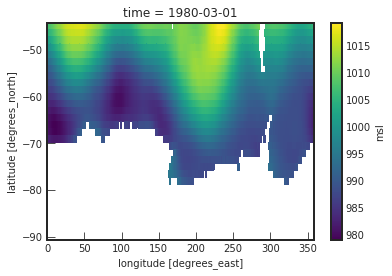

In [89]:
SLP_abs_tmon_merra[2,:,:].plot()

In [90]:
lat_vals = slp_tmon_merra.coords['lat']
lat_vals = lat_vals.sel(lat=slice(shem_ylo_slice, shem_yhi_slice)).values
lat_vals

array([-45. , -46.5, -48. , -49.5, -51. , -52.5, -54. , -55.5, -57. ,
       -58.5, -60. , -61.5, -63. , -64.5, -66. , -67.5, -69. , -70.5,
       -72. , -73.5, -75. , -76.5, -78. , -79.5, -81. , -82.5, -84. ,
       -85.5, -87. , -88.5, -90. ])

In [91]:
rad = round(4.0*np.arctan(1.0)/180.0,5)  #equals pi/180, rounding to conserve space
wlat = np.cos(lat_vals*rad)  #cos of lat
wlat

array([7.07211541e-01, 6.88465624e-01, 6.69248045e-01, 6.49571970e-01,
       6.29450879e-01, 6.08898557e-01, 5.87929083e-01, 5.66556824e-01,
       5.44796422e-01, 5.22662784e-01, 5.00171075e-01, 4.77336702e-01,
       4.54175310e-01, 4.30702767e-01, 4.06935153e-01, 3.82888751e-01,
       3.58580035e-01, 3.34025659e-01, 3.09242445e-01, 2.84247371e-01,
       2.59057562e-01, 2.33690275e-01, 2.08162888e-01, 1.82492891e-01,
       1.56697870e-01, 1.30795496e-01, 1.04803516e-01, 7.87397353e-02,
       5.26220108e-02, 2.64682354e-02, 2.96326791e-04])

In [92]:
ones_3d = np.ones(slp_tmon_merra.sel(lat=slice(shem_ylo_slice, shem_yhi_slice)).shape)
wlat_3d = ones_3d * wlat[np.newaxis, :, np.newaxis]
wlat_3d.shape

(456, 31, 240)

To weight, take zonal mean (brackets) of the product of the variable for the region (170E-298E) and the weight (cosine of lat), then sum across the latidinal band (80S-60S).  Divide this number by zonal mean (brackets) of the weights for the region (170E-298E) and sum latidinally (80S-60S)<br>


$$
\frac {\displaystyle\sum_{j=low}^{hi} \langle \cos(\lambda_j) *  VAR \rangle}{\displaystyle\sum_{j=low}^{hi} \langle \cos(\lambda_j) \rangle}
$$

In [93]:
numerator = SLP_abs_tmon_merra * wlat_3d
numerator_region = numerator.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).mean(dim='lon').sum(dim='lat')
#print (numerator_region.values, numerator_region.shape)

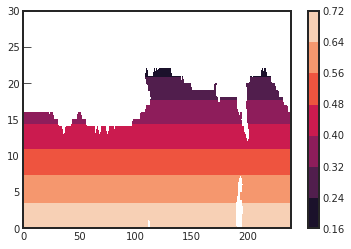

In [94]:
#turn the lat-weights into dask array for use in slicing next
da_wlat_3d = numerator / slp_tmon_merra
da_wlat_3d
plt.contourf(da_wlat_3d[0])
plt.colorbar()
plt.show()

In [95]:
denominator_region = da_wlat_3d.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).mean(dim='lon').sum(dim='lat')
#denominator_region.values

In [96]:
ASL_sectormean_tmon_merra = (numerator_region/denominator_region)
#ASL_sectormean_tmon_merra.values

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


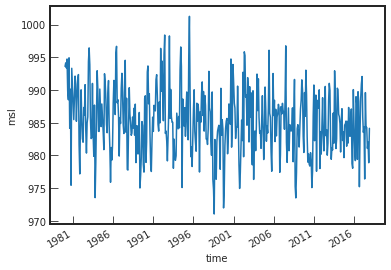

In [97]:
ASL_sectormean_tmon_merra.plot() #Verified with Hosking published data: C:\Users\Paul\Desktop\Tabor\Revisit_Monthly_ASL_indices_in_ERA_compared_to_Hosking_Published_Data.xlsx
# ASL_sectormean_tmon_merra.shape

In [98]:
#time series for the Abs CP Min vs Abs SLP sector mean and below that the Rel CP Min timeseries

In [99]:
#Abs CP Min
ASL_sectormin_tmon_merra = SLP_abs_tmon_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat'])
#ASL_sectormin_tmon_merra.plot()
#ASL_sectormin_tmon_merra.shape

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


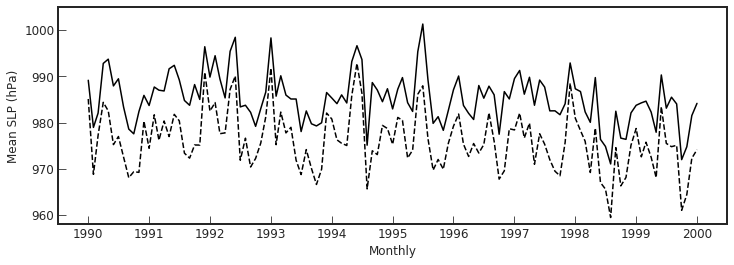

In [100]:
#Based on Hosking et al 2013, Fig. 2a
#mean slp of ASL sector (solid) and actual abs CP (dash)

x = slp_tmon_merra.coords['time'].values
y_asl_sector_mean_merra = ASL_sectormean_tmon_merra.values
y_asl_abs_cp_merra = ASL_sectormin_tmon_merra.values

sns.set_style('white')
sns.set_style('ticks',
              {'xtick.major.size':8, 'ytick.major.size':8,
               'xtick.direction': 'in', 'ytick.direction': 'in',
               'axes.linewidth':2 })
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 4),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)


fig, ax1 = plt.subplots()

ax1.set_xlabel('Monthly')
ax1.set_ylabel('Mean SLP (hPa)')
#ax1.set_xlim(132,253)
#ax1.xaxis.set(ticks=np.arange(132, 253, 12),
#             ticklabels=('0013','0014','0015','0016','0017','0018','0019','0020','0021','0022','0023'))
ax1.set_ylim(958,1005)
ax1.yaxis.set_ticks(np.arange(960, 1010, 10))
ax1.plot(x[132-12:253-12], y_asl_sector_mean_merra[132-12:253-12], color='k',linewidth=1.5)
ax1.plot(x[132-12:253-12], y_asl_abs_cp_merra[132-12:253-12], color='k',ls='--',linewidth=1.5)

plt.show()

In [122]:
ASL_sectormin_tmon_merra.values

array([988.5351 , 988.3    , 986.48206, 986.535  , 982.31976, 978.22076,
       983.98364, 978.36115, 980.3471 , 965.1463 , 983.95026, 984.55554,
       981.26154, 976.8631 , 977.8574 , 986.99164, 981.2903 , 974.8196 ,
       978.59845, 977.10345, 982.78015, 976.68   , 967.86194, 975.6943 ,
       983.61127, 979.73126, 974.2473 , 968.2488 , 977.0901 , 975.62384,
       983.8156 , 966.7991 , 968.9818 , 976.1613 , 975.8764 , 983.06494,
       986.94   , 985.569  , 978.3278 , 970.6679 , 975.0552 , 983.3739 ,
       975.29706, 970.4847 , 980.08185, 961.32025, 967.98914, 977.8691 ,
       982.40094, 984.22076, 975.7168 , 977.18896, 982.36255, 976.90967,
       972.1473 , 975.7667 , 973.0199 , 971.12036, 975.96375, 985.8141 ,
       985.84283, 982.13245, 977.8092 , 976.78357, 979.299  , 979.5028 ,
       971.6584 , 971.0447 , 969.6372 , 969.6841 , 970.2296 , 976.2235 ,
       983.2875 , 980.3732 , 983.06384, 980.145  , 980.99097, 977.09283,
       979.6422 , 979.98413, 976.11273, 968.98553, 

In [101]:
#correlation of ABSL actual CP and area-averaged MSLP in ASL region 0013-0023
#need to detrend these time series before comparing to one-another and to SAM index nino3.4 see page 4
fff = pearsonr(ASL_sectormean_tmon_merra.values,ASL_sectormin_tmon_merra.values)
print(fff)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(0.8886371916296509, 8.316352320952106e-156)


In [102]:
#Every month relative CP data for climatology time series

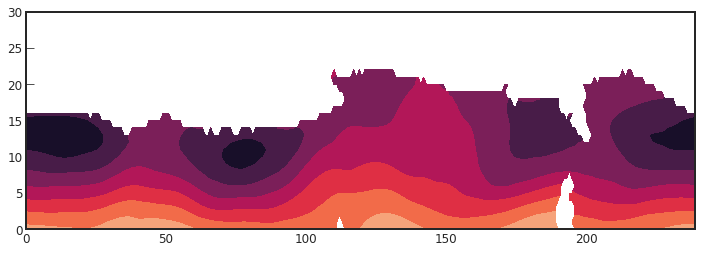

In [103]:
plt.contourf(SLP_abs_tmon_merra[0])

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


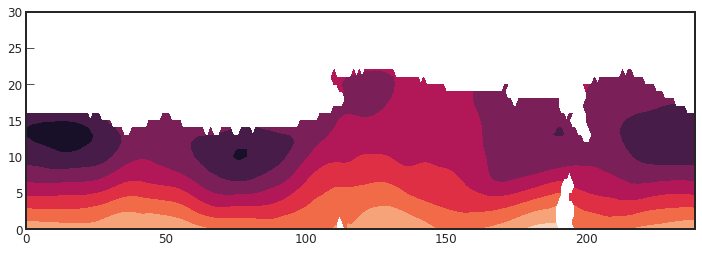

In [104]:
#RELATIVE SLP wrt ASL MEAN for each month
ASL_sector_relative_tmon_merra = SLP_abs_tmon_merra - ASL_sectormean_tmon_merra
ASL_sector_relative_tmon_merra.shape
plt.contourf(ASL_sector_relative_tmon_merra[0])

In [105]:
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

def detect_local_minima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima)

In [106]:
monthly_Rel_CP_location_lists = []
for t in np.arange(0,len(slp_tmon_merra.coords['time']),1): 
    current = []
    monthly_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = ASL_sector_relative_tmon_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(ASL_sector_relative_tmon_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == ASL_sector_relative_tmon_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        #print('In NW Region', t, t%12)
        #print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(ASL_sector_relative_tmon_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = ASL_sector_relative_tmon_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            #print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            #print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                #print(uuu)
                #print(uuu.values)
                #print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #print(uuu)
                #print(uuu.values)
                #print(all_loc_mins)

            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                #print(all_loc_mins[idx[0]][idx[0]].coords['lon'].values)
                #print(all_loc_mins[idx[0]][idx[0]].coords['lat'].values)
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #print(uuu)
                #print(uuu.values)
                #print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
##print(monthly_Rel_CP_location_lists)


#         #print('In NW Region', t, t%12)
#         #print(min_rel_cp)
#                     #print('Empty list of arrays for t=', t)
#             #print(yy)
#             #print(idx)
#             #print(uuu)
#             #print(uuu.values)
#             #print(all_loc_mins)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

In [107]:
len(monthly_Rel_CP_location_lists)

456

In [108]:
# monthly_Rel_CP_location_lists #now just one for each time step

In [109]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack

monthly_Rel_CP_location_lists_vals = []
for t in np.arange(0,len(slp_tmon_merra.coords['time']),1): 
   current = []
   monthly_Rel_CP_location_lists_vals.append(current)
   pp = monthly_Rel_CP_location_lists[t][0].values
   current.append(pp)
#print(monthly_Rel_CP_location_lists_vals)

# monthly_Rel_CP_location_lists_times = []
# for t in np.arange(0,len(slp_tmon_merra.coords['time']),1): 
#    current = []
#    monthly_Rel_CP_location_lists_times.append(current)
#    pp = monthly_Rel_CP_location_lists[t][0].coords['time'].values
#    current.append(pp)
# #print(monthly_Rel_CP_location_lists_times)

monthly_Rel_CP_location_lists_lats = []
for t in np.arange(0,len(slp_tmon_merra.coords['time']),1): 
   current = []
   monthly_Rel_CP_location_lists_lats.append(current)
   pp = monthly_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
#print(monthly_Rel_CP_location_lists_lats)

monthly_Rel_CP_location_lists_lons = []
for t in np.arange(0,len(slp_tmon_merra.coords['time']),1): 
   current = []
   monthly_Rel_CP_location_lists_lons.append(current)
   pp = monthly_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
#print(monthly_Rel_CP_location_lists_lons)

monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_merra = np.column_stack((monthly_Rel_CP_location_lists_vals, monthly_Rel_CP_location_lists_lats, monthly_Rel_CP_location_lists_lons))
monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_merra.shape

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(456, 3)

In [110]:
pd.to_datetime(slp_tmon_merra.coords['time'].values)

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', length=456, freq=None)

In [114]:
#Putting the Relative CP location information into a Pandas Dataframe
monthly_Rel_CP_location_info_merra_df = pd.DataFrame({
                    'time'         : pd.to_datetime(slp_tmon_merra.coords['time'].values),
                    'month_indice' : np.tile(np.arange(0,12,1), int(len(slp_tmon_merra.coords['time'])/12)),
                    'vals'         : monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_merra[:,0],
                    'lats'         : monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_merra[:,1],
                    'lons'         : monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_merra[:,2],
                   })
# monthly_Rel_CP_location_info_merra_df

#Make time the index column so that we can use resample for seasonal means
monthly_Rel_CP_location_info_merra_df.time = pd.to_datetime(slp_tmon_merra.coords['time'].values)
monthly_Rel_CP_location_info_merra_df.set_index('time', inplace=True)
monthly_Rel_CP_location_info_merra_df.head(n=5)
monthly_Rel_CP_location_info_merra_df.to_csv('Monthly_MERRA_Rel_CP_Loc.csv')

#Verified with Hosking published data: C:\Users\Paul\Desktop\Tabor\Revisit_Monthly_ASL_indices_in_ERA_compared_to_Hosking_Published_Data.xlsx
#Some differences in RelCP and Lon Lat occur due to how I "reselected" ASL CP... I think my method is more precise actually
#But, nearly identical sectormean vlaues to hosking

In [124]:
#Putting the Relative CP location information into a Pandas Dataframe
monthly_Rel_CP_location_info_merra_df = pd.DataFrame({
                    'time'         : pd.to_datetime(slp_tmon_merra.coords['time'].values),
                    'month_indice' : np.tile(np.arange(0,12,1), int(len(slp_tmon_merra.coords['time'])/12)),
                    'vals'         : monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_merra[:,0],
                    'sectormean'   : ASL_sectormean_tmon_merra[:],
                    'abs_pres'     : ASL_sectormin_tmon_merra[:],
                    'lats'         : monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_merra[:,1],
                    'lons'         : monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_merra[:,2],
                   })
# monthly_Rel_CP_location_info_merra_df

#Make time the index column so that we can use resample for seasonal means
monthly_Rel_CP_location_info_merra_df.time = pd.to_datetime(slp_tmon_merra.coords['time'].values)
monthly_Rel_CP_location_info_merra_df.set_index('time', inplace=True)
monthly_Rel_CP_location_info_merra_df.to_csv('Monthly_MERRA_Rel_CP_Loc.csv')
monthly_Rel_CP_location_info_merra_df.head(n=5)

#Verified with Hosking published data: C:\Users\Paul\Desktop\Tabor\Revisit_Monthly_ASL_indices_in_ERA_compared_to_Hosking_Published_Data.xlsx
#Some differences in RelCP and Lon Lat occur due to how I "reselected" ASL CP... I think my method is more precise actually
#But, nearly identical sectormean vlaues to hosking

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,month_indice,vals,sectormean,abs_pres,lats,lons
time,,,,,,
1980-01-01,0,-5.095507,993.630602,988.535095,-64.5,286.5
1980-02-01,1,-5.868897,994.168885,988.299988,-63.0,283.5
1980-03-01,2,-6.919626,993.401681,986.482056,-72.0,283.5
1980-04-01,3,-7.615094,994.757917,986.534973,-67.5,207.0
1980-05-01,4,-7.202291,989.837240,982.319763,-69.0,198.0


In [113]:
monthly_Rel_CP_location_info_merra_df
ASL_sectormean_tmon_merra.values

,month_indice,vals,lats,lons
time,,,,
1980-01-01,0,-5.095507,-64.5,286.5
1980-02-01,1,-5.868897,-63.0,283.5
1980-03-01,2,-6.919626,-72.0,283.5
1980-04-01,3,-7.615094,-67.5,207.0
1980-05-01,4,-7.202291,-69.0,198.0
1980-06-01,5,-10.304892,-75.0,211.5
1980-07-01,6,-10.956197,-72.0,205.5
1980-08-01,7,-5.802338,-72.0,199.5
1980-09-01,8,-9.792346,-67.5,259.5


# NEW - START

### Absolute Seasonal data and means:

In [112]:
SLP_abs_tmon_merra

<xarray.DataArray 'msl' (time: 456, lat: 31, lon: 240)>
dask.array<shape=(456, 31, 240), dtype=float32, chunksize=(1, 31, 240)>
Coordinates:
  * lat      (lat) float64 -45.0 -46.5 -48.0 -49.5 ... -85.5 -87.0 -88.5 -90.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

In [113]:
#Seasonal Mean
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
slp_abs_seas_merra = SLP_abs_tmon_merra[2:(len(SLP_abs_tmon_merra['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(axis=0)
slp_abs_seas_merra

<xarray.DataArray (time: 151, lat: 31, lon: 240)>
dask.array<shape=(151, 31, 240), dtype=float32, chunksize=(1, 31, 240)>
Coordinates:
  * time     (time) datetime64[ns] 1980-03-01 1980-06-01 1980-09-01 ...
  * lat      (lat) float64 -45.0 -46.5 -48.0 -49.5 -51.0 -52.5 -54.0 -55.5 ...
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 7.5 9.0 10.5 12.0 13.5 15.0 ...

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'time' (time: 37)>
array(['1980-12-01T00:00:00.000000000', '1981-12-01T00:00:00.000000000',
       '1982-12-01T00:00:00.000000000', '1983-12-01T00:00:00.000000000',
       '1984-12-01T00:00:00.000000000', '1985-12-01T00:00:00.000000000',
       '1986-12-01T00:00:00.000000000', '1987-12-01T00:00:00.000000000',
       '1988-12-01T00:00:00.000000000', '1989-12-01T00:00:00.000000000',
       '1990-12-01T00:00:00.000000000', '1991-12-01T00:00:00.000000000',
       '1992-12-01T00:00:00.000000000', '1993-12-01T00:00:00.000000000',
       '1994-12-01T00:00:00.000000000', '1995-12-01T00:00:00.000000000',
       '1996-12-01T00:00:00.000000000', '1997-12-01T00:00:00.000000000',
       '1998-12-01T00:00:00.000000000', '1999-12-01T00:00:00.000000000',
       '2000-12-01T00:00:00.000000000', '2001-12-01T00:00:00.000000000',
       '2002-12-01T00:00:00.000000000', '2003-12-01T00:00:00.000000000',
       '2004-12-01T00:00:00.000000000', '2005-12-01T00:00:00.000000000',
       '2006-1

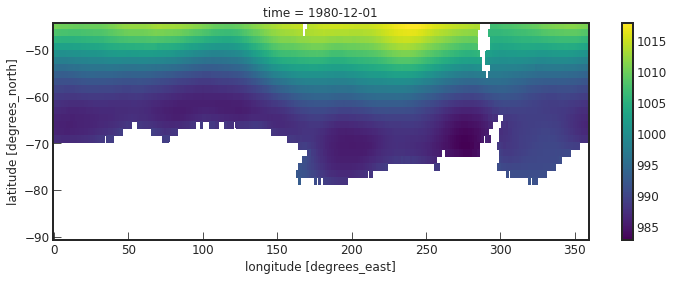

In [114]:
#Seperating out those seasonal means of the field variable
def is_djf(month):
    return (month == 12)

def is_mam(month):
    return (month == 3)

def is_jja(month):
    return (month == 6)

def is_son(month):
    return (month == 9)

djf_slp_abs_seas_merra = slp_abs_seas_merra.sel(time=is_djf(slp_abs_seas_merra['time.month']))
mam_slp_abs_seas_merra = slp_abs_seas_merra.sel(time=is_mam(slp_abs_seas_merra['time.month']))
jja_slp_abs_seas_merra = slp_abs_seas_merra.sel(time=is_jja(slp_abs_seas_merra['time.month']))
son_slp_abs_seas_merra = slp_abs_seas_merra.sel(time=is_son(slp_abs_seas_merra['time.month']))

#note, the first djf is dated for the first year because the 3-month mean is labeled by the first month
#Do not include the last value (0049) for DJF, as it only contains D
djf_slp_abs_seas_merra[0].plot()
print(djf_slp_abs_seas_merra.time)

#In case I need to add NaNs in djf, something like this may work:
# #need to add back in at time=0 a row of nans for djf, else it has 47 instead of 48 points
# nan_slice_for_djf = djfmean_T2M_tmon_merra_data[0:1,:,:]
# nan_slice_for_djf = nan_slice_for_djf.where(nan_slice_for_djf == 99999.)
# djfmean_T2M_tmon_merra_data = xr.concat([nan_slice_for_djf, djfmean_T2M_tmon_merra_data], dim='time')
# #djfmean_T2M_tmon_merra_data

<xarray.DataArray 'getitem-b2edb91b87598e499b33f7a9193d92c4' (time: 456, lat: 31, lon: 240)>
dask.array<shape=(456, 31, 240), dtype=float32, chunksize=(456, 31, 240)>
Coordinates:
  * lat      (lat) float64 -45.0 -46.5 -48.0 -49.5 -51.0 -52.5 -54.0 -55.5 ...
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 1980-03-01 ...
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 7.5 9.0 10.5 12.0 13.5 15.0 ...


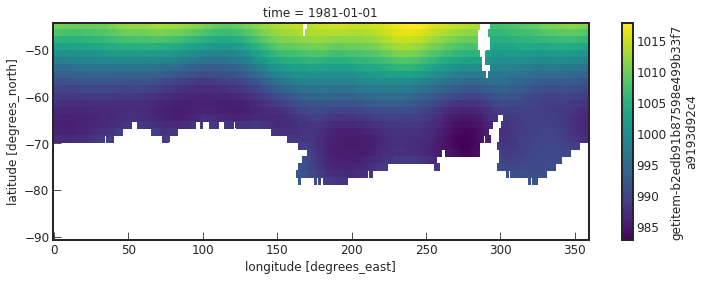

In [115]:
#Field variable with 3,6,12 roll and annual mean
SLP_abs_tmon_merra = SLP_abs_tmon_merra.chunk({'time':468})

slp_abs_roll3_mean_merra = SLP_abs_tmon_merra.rolling(time=3, min_periods=3, center=True).mean(axis=0)
print(slp_abs_roll3_mean_merra)
slp_abs_roll3_mean_merra[12].plot()

slp_abs_roll6_mean_merra = SLP_abs_tmon_merra.rolling(time=6, min_periods=6, center=True).mean(axis=0)
#slp_abs_roll6_mean_merra

slp_abs_roll12_mean_merra = SLP_abs_tmon_merra.rolling(time=12, min_periods=12, center=True).mean(axis=0)
#slp_abs_roll12_mean_merra

slp_abs_ann_mean_merra = SLP_abs_tmon_merra.resample(time='AS').mean(axis=0)
# slp_abs_ann_mean_merra

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packag

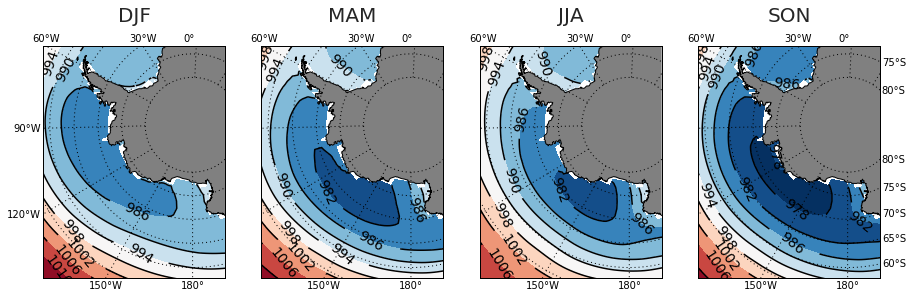

In [116]:
# setup Lambert Conformal basemap.
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)

lon, lat = np.meshgrid(slp_tmon_merra.coords['lon'].sel(lon=slice(shem_xlo_slice, shem_xhi_slice)).values,slp_tmon_merra.coords['lat'].sel(lat=slice(shem_ylo_slice, shem_yhi_slice)).values)

levels = np.arange(978,1018,4)

fig = plt.figure(figsize=(15,7))

#DJF
plt.subplot(1, 4, 1)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[True,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,djf_slp_abs_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,djf_slp_abs_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('DJF',y=1.08,fontsize=20)


#MAM
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 2)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,mam_slp_abs_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,mam_slp_abs_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('MAM',y=1.08,fontsize=20)


#JJA
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 3)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,jja_slp_abs_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,jja_slp_abs_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('JJA',y=1.08,fontsize=20)


#SON
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 4)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,son_slp_abs_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,son_slp_abs_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('SON',y=1.08,fontsize=20)

# plt.savefig(FIG_PATH+'/merra_fig1.png',bbox_inches='tight', pad_inches=0.01)

plt.show()

### Hosking et al 2013 definition relative SLP.  I need to subtract off the seasonal mean for each year from the seasonal mean abs CP.

In [117]:
ASL_sectormean_tmon_merra.time

<xarray.DataArray 'time' (time: 456)>
array(['1980-01-01T00:00:00.000000000', '1980-02-01T00:00:00.000000000',
       '1980-03-01T00:00:00.000000000', ..., '2017-10-01T00:00:00.000000000',
       '2017-11-01T00:00:00.000000000', '2017-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 1980-03-01 ...
Attributes:
    standard_name:  time
    long_name:      time

In [118]:
#Seasonal Mean
#Seasonal Mean of Sectormean, just an example here to make sure my method below is correct
ASL_sectormean_seas_merra = ASL_sectormean_tmon_merra[2:(len(ASL_sectormean_tmon_merra['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(axis=0)
print(ASL_sectormean_seas_merra[0].values) #MAM for 0002 
print(ASL_sectormean_seas_merra[0])
ASL_sectormean_seas_merra

992.6656125661057
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1980-03-01


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (time: 151)>
dask.array<shape=(151,), dtype=float64, chunksize=(1,)>
Coordinates:
  * time     (time) datetime64[ns] 1980-03-01 1980-06-01 1980-09-01 ...

In [119]:
#Seasonal Mean continue
djf_ASL_sectormean_seas_merra = ASL_sectormean_seas_merra.sel(time=is_djf(ASL_sectormean_seas_merra['time.month']))
mam_ASL_sectormean_seas_merra = ASL_sectormean_seas_merra.sel(time=is_mam(ASL_sectormean_seas_merra['time.month']))
jja_ASL_sectormean_seas_merra = ASL_sectormean_seas_merra.sel(time=is_jja(ASL_sectormean_seas_merra['time.month']))
son_ASL_sectormean_seas_merra = ASL_sectormean_seas_merra.sel(time=is_son(ASL_sectormean_seas_merra['time.month']))

print(mam_ASL_sectormean_seas_merra[0].values)
print(mam_ASL_sectormean_seas_merra[0])

#Rolling means and annual mean
ASL_sectormean_tmon_merra = ASL_sectormean_tmon_merra.chunk({'time':468})

ASL_sectormean_roll3_mean_merra = ASL_sectormean_tmon_merra.rolling(time=3, min_periods=3, center=True).mean(axis=0)
print(ASL_sectormean_roll3_mean_merra[3].values)
print(ASL_sectormean_roll3_mean_merra[3])

ASL_sectormean_roll6_mean_merra = ASL_sectormean_tmon_merra.rolling(time=6, min_periods=6, center=True).mean(axis=0)

ASL_sectormean_roll12_mean_merra = ASL_sectormean_tmon_merra.rolling(time=12, min_periods=12, center=True).mean(axis=0)

ASL_sectormean_ann_mean_merra = ASL_sectormean_tmon_merra.resample(time='AS').mean(axis=0)



/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


992.6656125661057
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1980-03-01
992.6656125661057
<xarray.DataArray 'getitem-7d08d329a91ee3384d9092f873b72843' ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1980-04-01


In [120]:
#calculating relative slp in the ASL sector
djf_slp_rel_cp_asl_seas_merra = (djf_slp_abs_seas_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - djf_ASL_sectormean_seas_merra )
mam_slp_rel_cp_asl_seas_merra = (mam_slp_abs_seas_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - mam_ASL_sectormean_seas_merra )
jja_slp_rel_cp_asl_seas_merra = (jja_slp_abs_seas_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - jja_ASL_sectormean_seas_merra )
son_slp_rel_cp_asl_seas_merra = (son_slp_abs_seas_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - son_ASL_sectormean_seas_merra )
roll3_slp_rel_cp_asl_merra = (slp_abs_roll3_mean_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - ASL_sectormean_roll3_mean_merra )
roll6_slp_rel_cp_asl_merra = (slp_abs_roll6_mean_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - ASL_sectormean_roll6_mean_merra )
roll12_slp_rel_cp_asl_merra = (slp_abs_roll12_mean_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - ASL_sectormean_roll12_mean_merra )
ann_mean_slp_rel_cp_asl_merra = (slp_abs_ann_mean_merra.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - ASL_sectormean_ann_mean_merra )


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packag

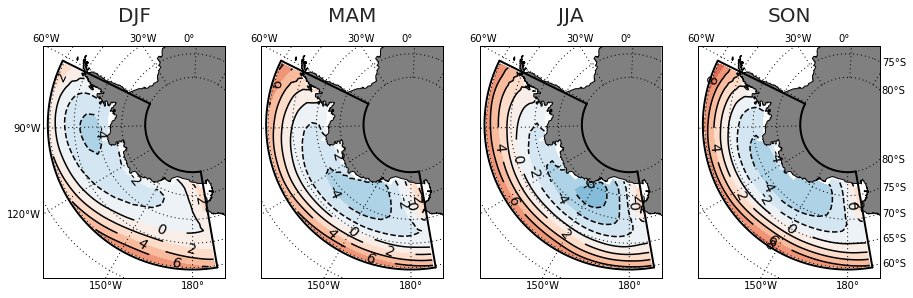

In [121]:
# setup Lambert Conformal basemap.
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)

lon, lat = np.meshgrid(slp_tmon_merra.coords['lon'].sel(lon=slice(asl_xlo_slice, asl_xhi_slice)).values,slp_tmon_merra.coords['lat'].sel(lat=slice(asl_ylo_slice, asl_yhi_slice)).values)

levels = np.arange(-16,18,2)

fig = plt.figure(figsize=(15,7))

plt.subplot(1, 4, 1)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[True,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,djf_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,djf_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('DJF',y=1.08,fontsize=20)

#Add ASL Box
lat_line = np.linspace(-59.6,-59.6,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2) 

lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-190,-190,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-62,-62,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)


#MAM
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 2)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,mam_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,mam_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('MAM',y=1.08,fontsize=20)

#Add ASL Box
lat_line = np.linspace(-59.6,-59.6,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2) 

lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-190,-190,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-62,-62,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)


#JJA
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 3)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,jja_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,jja_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('JJA',y=1.08,fontsize=20)

#Add ASL Box
lat_line = np.linspace(-59.6,-59.6,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2) 

lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-190,-190,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-62,-62,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)


#SON
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 4)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,son_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,son_slp_rel_cp_asl_seas_merra.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('SON',y=1.08,fontsize=20)

#Add ASL Box
lat_line = np.linspace(-59.6,-59.6,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2) 

lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-190,-190,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-62,-62,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

# plt.savefig(FIG_PATH+'/merra_fig2.png',bbox_inches='tight', pad_inches=0.01)



plt.show()

### Finding the ASL CP for each time period

In [122]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [123]:
djfmean_Rel_CP_location_lists = []
for t in np.arange(0,len(djf_slp_rel_cp_asl_seas_merra.coords['time']),1): 
    current = []
    djfmean_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = djf_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(djf_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == djf_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(djf_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = djf_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(djfmean_Rel_CP_location_lists)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

[[<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1980-12-01
    lat      float64 -70.5
    lon      float64 276.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1981-12-01
    lat      float64 -69.0
    lon      float64 265.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1982-12-01
    lat      float64 -64.5
    lon      float64 279.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1983-12-01
    lat      float64 -67.5
    lon      float64 253.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1984-12-01
    lat      float64 -66.0
    lon      float64 264.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [124]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#DJF
djfmean_Rel_CP_vals = []
for t in np.arange(0,len(djf_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   djfmean_Rel_CP_vals.append(current)
   pp = djfmean_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in djfmean_Rel_CP_vals:
    merged_list += l
djfmean_Rel_CP_vals = np.asarray(merged_list)
#print(djfmean_Rel_CP_vals)


djfmean_Rel_CP_times = []
for t in np.arange(0,len(djf_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   djfmean_Rel_CP_times.append(current)
   pp = djfmean_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in djfmean_Rel_CP_times:
    merged_list += l
djfmean_Rel_CP_times = np.asarray(merged_list)
#print(djfmean_Rel_CP_times)


djfmean_Rel_CP_lats = []
for t in np.arange(0,len(djf_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   djfmean_Rel_CP_lats.append(current)
   pp = djfmean_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in djfmean_Rel_CP_lats:
    merged_list += l
djfmean_Rel_CP_lats = np.asarray(merged_list)
#print(djfmean_Rel_CP_lats)


djfmean_Rel_CP_lons = []
for t in np.arange(0,len(djf_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   djfmean_Rel_CP_lons.append(current)
   pp = djfmean_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in djfmean_Rel_CP_lons:
    merged_list += l
djfmean_Rel_CP_lons = np.asarray(merged_list)
#print(djfmean_Rel_CP_lons)

d = {'time': djfmean_Rel_CP_times, 'vals': djfmean_Rel_CP_vals, 'lats': djfmean_Rel_CP_lats, 'lons': djfmean_Rel_CP_lons, 'sectormean': djf_ASL_sectormean_seas_merra.values, 'indice': np.arange(0, len(djf_ASL_sectormean_seas_merra.values),1)}
djfmean_ASL_Relative_CP_Location_info_merra = pd.DataFrame(data=d)
djfmean_ASL_Relative_CP_Location_info_merra.set_index('time', inplace=True)
djfmean_ASL_Relative_CP_Location_info_merra

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,vals,lats,lons,sectormean,indice
time,,,,,
1980-12-01,-5.507777,-70.5,276.0,988.218715,0
1981-12-01,-5.032051,-69.0,265.5,986.659493,1
1982-12-01,-8.317850,-64.5,279.0,994.900186,2
1983-12-01,-6.575958,-67.5,253.5,989.702972,3
1984-12-01,-4.701659,-66.0,264.0,990.748289,4
1985-12-01,-6.621764,-69.0,252.0,986.990905,5
1986-12-01,-6.603094,-67.5,259.5,989.255865,6
1987-12-01,-6.379322,-69.0,265.5,987.079273,7
1988-12-01,-5.985875,-66.0,265.5,983.095800,8


In [125]:
mammean_Rel_CP_location_lists = []
for t in np.arange(0,len(mam_slp_rel_cp_asl_seas_merra.coords['time']),1): 
    current = []
    mammean_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = mam_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(mam_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == mam_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(mam_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = mam_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(mammean_Rel_CP_location_lists)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In NW Region 0
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
    time     datetime64[ns] 1980-03-01
  * lat      (lat) float64 -66.0
  * lon      (lon) float64 171.0
[ 0.49533714 -5.93703591  0.50070823  0.51474632  0.56320823 -5.7951902
 -5.83504616  0.65445579 -5.81771218  2.88858665]
[1 6 8]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1980-03-01
    lat      float64 -70.5
    lon      float64 193.5
-5.835046159855665
<xarray.DataArray (lat: 10, lon: 10)>
dask.array<shape=(10, 10), dtype=float64, chunksize=(10, 10)>
Coordinates:
    time     datetime64[ns] 1980-03-01
  * lat      (lat) float64 -64.5 -66.0 -66.0 -69.0 -69.0 -70.5 -70.5 -70.5 ...
  * lon      (lon) float64 297.0 171.0 294.0 288.0 292.5 190.5 193.5 285.0 ...


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

In NW Region 6
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
    time     datetime64[ns] 1986-03-01
  * lat      (lat) float64 -66.0
  * lon      (lon) float64 171.0
[ 1.19099439 -6.36369311  0.03230298  0.82020581 -5.70646655  0.08039868
 -0.11772143 -5.40409839 -5.33628833 -5.29429614 -5.24223315]
[1 4 7]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1986-03-01
    lat      float64 -70.5
    lon      float64 190.5
-5.404098385665293
<xarray.DataArray (lat: 11, lon: 11)>
dask.array<shape=(11, 11), dtype=float64, chunksize=(11, 11)>
Coordinates:
    time     datetime64[ns] 1986-03-01
  * lat      (lat) float64 -64.5 -66.0 -66.0 -66.0 -67.5 -67.5 -69.0 -70.5 ...
  * lon      (lon) float64 297.0 171.0 286.5 294.0 181.5 279.0 265.5 190.5 ...
In NW Region 10
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

[-5.9959147   2.65160727 -2.38159586 -2.39233804 -2.38574625 -1.56079508
 -2.93402506]
[0 6 3]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1990-03-01
    lat      float64 -70.5
    lon      float64 210.0
-2.9340250563955124
<xarray.DataArray (lat: 7, lon: 7)>
dask.array<shape=(7, 7), dtype=float64, chunksize=(7, 7)>
Coordinates:
    time     datetime64[ns] 1990-03-01
  * lat      (lat) float64 -64.5 -64.5 -69.0 -69.0 -69.0 -69.0 -70.5
  * lon      (lon) float64 174.0 297.0 232.5 235.5 240.0 264.0 210.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

[[<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1980-03-01
    lat      float64 -70.5
    lon      float64 193.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1981-03-01
    lat      float64 -72.0
    lon      float64 210.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1982-03-01
    lat      float64 -70.5
    lon      float64 271.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1983-03-01
    lat      float64 -70.5
    lon      float64 214.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1984-03-01
    lat      float64 -73.5
    lon      float64 202.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [126]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#MAM
mammean_Rel_CP_vals = []
for t in np.arange(0,len(mam_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   mammean_Rel_CP_vals.append(current)
   pp = mammean_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in mammean_Rel_CP_vals:
    merged_list += l
mammean_Rel_CP_vals = np.asarray(merged_list)
#print(mammean_Rel_CP_vals)


mammean_Rel_CP_times = []
for t in np.arange(0,len(mam_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   mammean_Rel_CP_times.append(current)
   pp = mammean_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in mammean_Rel_CP_times:
    merged_list += l
mammean_Rel_CP_times = np.asarray(merged_list)
#print(mammean_Rel_CP_times)


mammean_Rel_CP_lats = []
for t in np.arange(0,len(mam_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   mammean_Rel_CP_lats.append(current)
   pp = mammean_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in mammean_Rel_CP_lats:
    merged_list += l
mammean_Rel_CP_lats = np.asarray(merged_list)
#print(mammean_Rel_CP_lats)


mammean_Rel_CP_lons = []
for t in np.arange(0,len(mam_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   mammean_Rel_CP_lons.append(current)
   pp = mammean_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in mammean_Rel_CP_lons:
    merged_list += l
mammean_Rel_CP_lons = np.asarray(merged_list)
#print(mammean_Rel_CP_lons)

d = {'time': mammean_Rel_CP_times, 'vals': mammean_Rel_CP_vals, 'lats': mammean_Rel_CP_lats, 'lons': mammean_Rel_CP_lons, 'sectormean': mam_ASL_sectormean_seas_merra.values, 'indice': np.arange(0, len(mam_ASL_sectormean_seas_merra.values),1)}
mammean_ASL_Relative_CP_Location_info_merra = pd.DataFrame(data=d)
mammean_ASL_Relative_CP_Location_info_merra.set_index('time', inplace=True)
mammean_ASL_Relative_CP_Location_info_merra

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,vals,lats,lons,sectormean,indice
time,,,,,
1980-03-01,-5.835046,-70.5,193.5,992.665613,0
1981-03-01,-7.129560,-72.0,210.0,990.553876,1
1982-03-01,-10.269103,-70.5,271.5,983.985899,2
1983-03-01,-8.309083,-70.5,214.5,983.680970,3
1984-03-01,-6.138150,-73.5,202.5,985.847196,4
1985-03-01,-6.816673,-70.5,222.0,985.914390,5
1986-03-01,-5.404098,-70.5,190.5,990.739120,6
1987-03-01,-4.867724,-67.5,258.0,985.898486,7
1988-03-01,-8.098715,-70.5,210.0,983.840841,8


In [127]:
jjamean_Rel_CP_location_lists = []
for t in np.arange(0,len(jja_slp_rel_cp_asl_seas_merra.coords['time']),1): 
    current = []
    jjamean_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = jja_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(jja_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == jja_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(jja_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = jja_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(jjamean_Rel_CP_location_lists)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

In NW Region 22
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
    time     datetime64[ns] 2002-06-01
  * lat      (lat) float64 -67.5
  * lon      (lon) float64 183.0
[ 1.84547586  1.81471414 -6.70664816  0.01393289  0.36439676 -6.19492941
 -3.21964865 -3.60709982 -3.53636008 -2.92844992 -2.80320578 -2.40470724
 -3.76927023 -3.98423605 -3.34757834 -2.54044943 -2.55021506 -3.13303976
 -6.36802511 -6.38151388 -6.28220968]
[ 2 19 18]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 2002-06-01
    lat      float64 -75.0
    lon      float64 207.0
-6.381513883946923
<xarray.DataArray (lat: 21, lon: 21)>
dask.array<shape=(21, 21), dtype=float64, chunksize=(21, 21)>
Coordinates:
    time     datetime64[ns] 2002-06-01
  * lat      (lat) float64 -64.5 -66.0 -67.5 -69.0 -69.0 -72.0 -72.0 -72.0 ...
  * lon      (lon) float64 297.0 294.0 183.0 288.0 292.5 196.5 259.5 264.0 .

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

[[<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1980-06-01
    lat      float64 -72.0
    lon      float64 205.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1981-06-01
    lat      float64 -72.0
    lon      float64 249.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1982-06-01
    lat      float64 -73.5
    lon      float64 202.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1983-06-01
    lat      float64 -72.0
    lon      float64 222.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1984-06-01
    lat      float64 -75.0
    lon      float64 211.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

In [128]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#JJA
jjamean_Rel_CP_vals = []
for t in np.arange(0,len(jja_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   jjamean_Rel_CP_vals.append(current)
   pp = jjamean_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in jjamean_Rel_CP_vals:
    merged_list += l
jjamean_Rel_CP_vals = np.asarray(merged_list)
#print(jjamean_Rel_CP_vals)


jjamean_Rel_CP_times = []
for t in np.arange(0,len(jja_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   jjamean_Rel_CP_times.append(current)
   pp = jjamean_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in jjamean_Rel_CP_times:
    merged_list += l
jjamean_Rel_CP_times = np.asarray(merged_list)
#print(jjamean_Rel_CP_times)


jjamean_Rel_CP_lats = []
for t in np.arange(0,len(jja_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   jjamean_Rel_CP_lats.append(current)
   pp = jjamean_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in jjamean_Rel_CP_lats:
    merged_list += l
jjamean_Rel_CP_lats = np.asarray(merged_list)
#print(jjamean_Rel_CP_lats)


jjamean_Rel_CP_lons = []
for t in np.arange(0,len(jja_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   jjamean_Rel_CP_lons.append(current)
   pp = jjamean_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in jjamean_Rel_CP_lons:
    merged_list += l
jjamean_Rel_CP_lons = np.asarray(merged_list)
#print(jjamean_Rel_CP_lons)

d = {'time': jjamean_Rel_CP_times, 'vals': jjamean_Rel_CP_vals, 'lats': jjamean_Rel_CP_lats, 'lons': jjamean_Rel_CP_lons, 'sectormean': jja_ASL_sectormean_seas_merra.values, 'indice': np.arange(0, len(jja_ASL_sectormean_seas_merra.values),1)}
jjamean_ASL_Relative_CP_Location_info_merra = pd.DataFrame(data=d)
jjamean_ASL_Relative_CP_Location_info_merra.set_index('time', inplace=True)
jjamean_ASL_Relative_CP_Location_info_merra

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,vals,lats,lons,sectormean,indice
time,,,,,
1980-06-01,-8.322697,-72.0,205.5,989.209659,0
1981-06-01,-8.576666,-72.0,249.0,988.541815,1
1982-06-01,-11.051588,-73.5,202.5,986.956679,2
1983-06-01,-6.436939,-72.0,222.0,984.752186,3
1984-06-01,-9.011281,-75.0,211.5,986.577199,4
1985-06-01,-9.000356,-73.5,220.5,985.741750,5
1986-06-01,-9.755645,-66.0,291.0,991.096710,6
1987-06-01,-11.474602,-72.0,195.0,989.722710,7
1988-06-01,-10.571336,-72.0,198.0,985.765977,8


In [129]:
sonmean_Rel_CP_location_lists = []
for t in np.arange(0,len(son_slp_rel_cp_asl_seas_merra.coords['time']),1): 
    current = []
    sonmean_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = son_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(son_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == son_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(son_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = son_slp_rel_cp_asl_seas_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(sonmean_Rel_CP_location_lists)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

[[<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1980-09-01
    lat      float64 -70.5
    lon      float64 250.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1981-09-01
    lat      float64 -69.0
    lon      float64 274.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1982-09-01
    lat      float64 -73.5
    lon      float64 214.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1983-09-01
    lat      float64 -75.0
    lon      float64 201.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1984-09-01
    lat      float64 -75.0
    lon      float64 201.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

In [130]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#SON
sonmean_Rel_CP_vals = []
for t in np.arange(0,len(son_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   sonmean_Rel_CP_vals.append(current)
   pp = sonmean_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in sonmean_Rel_CP_vals:
    merged_list += l
sonmean_Rel_CP_vals = np.asarray(merged_list)
#print(sonmean_Rel_CP_vals)


sonmean_Rel_CP_times = []
for t in np.arange(0,len(son_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   sonmean_Rel_CP_times.append(current)
   pp = sonmean_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in sonmean_Rel_CP_times:
    merged_list += l
sonmean_Rel_CP_times = np.asarray(merged_list)
#print(sonmean_Rel_CP_times)


sonmean_Rel_CP_lats = []
for t in np.arange(0,len(son_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   sonmean_Rel_CP_lats.append(current)
   pp = sonmean_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in sonmean_Rel_CP_lats:
    merged_list += l
sonmean_Rel_CP_lats = np.asarray(merged_list)
#print(sonmean_Rel_CP_lats)


sonmean_Rel_CP_lons = []
for t in np.arange(0,len(son_slp_rel_cp_asl_seas_merra.coords['time']),1): 
   current = []
   sonmean_Rel_CP_lons.append(current)
   pp = sonmean_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in sonmean_Rel_CP_lons:
    merged_list += l
sonmean_Rel_CP_lons = np.asarray(merged_list)
#print(sonmean_Rel_CP_lons)

d = {'time': sonmean_Rel_CP_times, 'vals': sonmean_Rel_CP_vals, 'lats': sonmean_Rel_CP_lats, 'lons': sonmean_Rel_CP_lons, 'sectormean': son_ASL_sectormean_seas_merra.values, 'indice': np.arange(0, len(son_ASL_sectormean_seas_merra.values),1)}
sonmean_ASL_Relative_CP_Location_info_merra = pd.DataFrame(data=d)
sonmean_ASL_Relative_CP_Location_info_merra.set_index('time', inplace=True)
sonmean_ASL_Relative_CP_Location_info_merra

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,vals,lats,lons,sectormean,indice
time,,,,,
1980-09-01,-6.333974,-70.5,250.5,986.307851,0
1981-09-01,-5.489302,-69.0,274.5,983.732405,1
1982-09-01,-7.282599,-73.5,214.5,983.753790,2
1983-09-01,-8.321798,-75.0,201.0,980.063314,3
1984-09-01,-7.164777,-75.0,201.0,983.428998,4
1985-09-01,-8.819010,-75.0,207.0,978.809793,5
1986-09-01,-9.346639,-75.0,207.0,983.872029,6
1987-09-01,-6.403223,-70.5,271.5,981.461145,7
1988-09-01,-6.503598,-69.0,235.5,983.294431,8


#### Rolls take a long time to find mins, so run when i have time

In [ ]:
roll3_Rel_CP_location_lists = []
#for roll3, crop off the nans and beginning and end
for t in np.arange(1,len(roll3_slp_rel_cp_asl_merra.coords['time'])-1,1): 
    current = []
    roll3_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = roll3_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(roll3_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == roll3_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    print(min_rel_cp.values)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(roll3_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = roll3_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(roll3_Rel_CP_location_lists)

In [ ]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#3roll
roll3_Rel_CP_vals = []
#for roll3, crop off the nans and beginning and end
for t in np.arange(0,len(roll3_slp_rel_cp_asl_merra.coords['time'])-2,1): 
   current = []
   roll3_Rel_CP_vals.append(current)
   pp = roll3_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in roll3_Rel_CP_vals:
    merged_list += l
roll3_Rel_CP_vals = np.asarray(merged_list)
#print(roll3_Rel_CP_vals)


roll3_Rel_CP_times = []
#for roll3, crop off the nans and beginning and end
for t in np.arange(0,len(roll3_slp_rel_cp_asl_merra.coords['time'])-2,1): 
   current = []
   roll3_Rel_CP_times.append(current)
   pp = roll3_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in roll3_Rel_CP_times:
    merged_list += l
roll3_Rel_CP_times = np.asarray(merged_list)
#print(roll3_Rel_CP_times)


roll3_Rel_CP_lats = []
#for roll3, crop off the nans and beginning and end
for t in np.arange(0,len(roll3_slp_rel_cp_asl_merra.coords['time'])-2,1): 
   current = []
   roll3_Rel_CP_lats.append(current)
   pp = roll3_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in roll3_Rel_CP_lats:
    merged_list += l
roll3_Rel_CP_lats = np.asarray(merged_list)
#print(roll3_Rel_CP_lats)


roll3_Rel_CP_lons = []
#for roll3, crop off the nans and beginning and end
for t in np.arange(0,len(roll3_slp_rel_cp_asl_merra.coords['time'])-2,1): 
   current = []
   roll3_Rel_CP_lons.append(current)
   pp = roll3_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in roll3_Rel_CP_lons:
    merged_list += l
roll3_Rel_CP_lons = np.asarray(merged_list)
#print(roll3_Rel_CP_lons)

# d = {'time': roll3_Rel_CP_times, 'vals': roll3_Rel_CP_vals, 'lats': roll3_Rel_CP_lats, 'lons': roll3_Rel_CP_lons, 'sectormean': ASL_sectormean_roll3_mean_merra[1:-1].values, 'indice': np.arange(0, len(ASL_sectormean_roll3_mean_merra[1:-1].values),1)}
# roll3_ASL_Relative_CP_Location_info_merra = pd.DataFrame(data=d)
# roll3_ASL_Relative_CP_Location_info_merra.set_index('time', inplace=True)
# roll3_ASL_Relative_CP_Location_info_merra

In [ ]:
d = {'time': roll3_Rel_CP_times, 'vals': roll3_Rel_CP_vals, 'lats': roll3_Rel_CP_lats, 'lons': roll3_Rel_CP_lons, 'sectormean': ASL_sectormean_roll3_mean_merra[1:-1].values, 'indice': np.arange(0, len(ASL_sectormean_roll3_mean_merra[1:-1].values),1)}
roll3_ASL_Relative_CP_Location_info_merra = pd.DataFrame(data=d)
roll3_ASL_Relative_CP_Location_info_merra.set_index('time', inplace=True)
roll3_ASL_Relative_CP_Location_info_merra.to_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_3roll_mean.pkl')
roll3_ASL_Relative_CP_Location_info_merra

In [131]:
roll6_Rel_CP_location_lists = []
#for roll6, crop off the nans and beginning and end
for t in np.arange(3,len(roll6_slp_rel_cp_asl_merra.coords['time'])-2,1): 
    current = []
    roll6_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = roll6_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(roll6_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == roll6_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    print(min_rel_cp.values)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(roll6_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = roll6_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(roll6_Rel_CP_location_lists)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.97342273]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.92191452]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.93842948]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.90967843]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.2069178]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.1709866]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.13381768]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.35207653]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.01017012]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.17596657]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.41864967]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.91962072]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.90568607]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.8570887]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.2713561]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.08094279]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.96710974]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.73439993]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.45337601]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.70346207]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.23110521]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.58520579]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.14024542]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.43335285]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.24166222]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.01178137]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.69809572]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.27752263]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.65994214]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.99567626]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.81697344]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.27513093]]
In NW Region 34
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
  * lat      (lat) float64 -66.0
    time     datetime64[ns] 1982-11-01
  * lon      (lon) float64 171.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[ 3.1957553  -6.27513093  2.41914398  1.1856845  -3.94236725 -4.20884675
 -5.61131257 -3.98442048]
[1 6 5]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -73.5
    time     datetime64[ns] 1982-11-01
    lon      float64 202.5
-5.6113125666183805
<xarray.DataArray (lat: 8, lon: 8)>
dask.array<shape=(8, 8), dtype=float64, chunksize=(8, 8)>
Coordinates:
  * lat      (lat) float64 -64.5 -66.0 -66.0 -69.0 -72.0 -72.0 -73.5 -73.5
    time     datetime64[ns] 1982-11-01
  * lon      (lon) float64 297.0 171.0 294.0 292.5 237.0 250.5 202.5 232.5


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.98055264]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.79420653]]
In NW Region 36
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
  * lat      (lat) float64 -66.0
    time     datetime64[ns] 1983-01-01
  * lon      (lon) float64 171.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[-0.76771727 -4.79420653 -1.28749267 -4.35792724 -4.13746825 -1.84706298
 -2.08674804 -2.22908202 -2.30262938 -2.42152587]
[1 3 4]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -69.0
    time     datetime64[ns] 1983-01-01
    lon      float64 276.0
-4.357927235596662
<xarray.DataArray (lat: 10, lon: 10)>
dask.array<shape=(10, 10), dtype=float64, chunksize=(10, 10)>
Coordinates:
  * lat      (lat) float64 -64.5 -66.0 -66.0 -69.0 -70.5 -72.0 -72.0 -72.0 ...
    time     datetime64[ns] 1983-01-01
  * lon      (lon) float64 297.0 171.0 294.0 276.0 262.5 210.0 222.0 226.5 ...


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.1408742]]
In NW Region 37
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
  * lat      (lat) float64 -66.0
    time     datetime64[ns] 1983-02-01
  * lon      (lon) float64 171.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[ 1.64556379 -4.1408742   0.98699445 -3.21515399 -2.28802996 -2.97974139
 -3.08276873 -2.80219012 -3.15448504]
[1 3 8]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -69.0
    time     datetime64[ns] 1983-02-01
    lon      float64 265.5
-3.2151539882257794
<xarray.DataArray (lat: 9, lon: 9)>
dask.array<shape=(9, 9), dtype=float64, chunksize=(9, 9)>
Coordinates:
  * lat      (lat) float64 -64.5 -66.0 -66.0 -69.0 -70.5 -70.5 -70.5 -70.5 -70.5
    time     datetime64[ns] 1983-02-01
  * lon      (lon) float64 297.0 171.0 294.0 265.5 193.5 217.5 225.0 240.0 261.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.89531447]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.84897906]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.71051199]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.02224187]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.40529467]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.48500852]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.01279136]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.07449489]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.76938148]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.8065439]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.92507696]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.5810724]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.93658296]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.31474407]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.61625708]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.47062037]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.7072612]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.48758072]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.995347]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.82172322]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.79937104]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.30653907]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.64221746]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.43551881]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.48649102]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.5634856]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.21622954]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.56104116]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.6845558]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.61617699]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.6816554]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.21580414]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.028958]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.68745852]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.92866178]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.67429692]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.59572561]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.67174829]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.47468913]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.58783696]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.3431386]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.90253724]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.83916702]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.93918593]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.29465248]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.54234075]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.48890748]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.59673582]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.7351342]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.51228984]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.97012754]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.88420601]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.87518415]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.79997064]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.11036]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.77535973]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.56778699]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.08942288]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.05360627]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.80209337]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.58542343]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.28073374]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.71054632]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-9.05279871]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-9.05685991]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.12660967]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.56316268]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.2814432]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.30313288]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.06218069]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.84167532]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.32698489]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.68229281]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.80864577]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.74462975]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.55351876]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.13613705]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.90216475]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.27130189]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.49148841]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.70165945]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.39948946]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.6253866]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.21769505]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.47572119]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.96497504]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.3776922]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.66636261]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.86135288]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.20813369]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.83713362]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.75769983]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.41508863]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.03429706]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.41061887]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.7529059]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.43157167]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.23252678]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.22070427]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.48938722]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.7053168]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-9.61413389]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.39399686]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.37011754]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.45161408]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.99798394]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.51848899]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.79294886]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.01701244]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.45727275]]
In NW Region 147
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
  * lat      (lat) float64 -66.0
    time     datetime64[ns] 1992-04-01
  * lon      (lon) float64 171.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[ 0.85364033 -5.45727275  0.2598293   0.59826924 -5.45580791 -5.40173076
 -0.19799541  0.18481709 -0.87292217]
[1 4 5]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -69.0
    time     datetime64[ns] 1992-04-01
    lon      float64 186.0
-5.401730762454463
<xarray.DataArray (lat: 9, lon: 9)>
dask.array<shape=(9, 9), dtype=float64, chunksize=(9, 9)>
Coordinates:
  * lat      (lat) float64 -64.5 -66.0 -66.0 -66.0 -67.5 -69.0 -69.0 -72.0 -72.0
    time     datetime64[ns] 1992-04-01
  * lon      (lon) float64 297.0 171.0 291.0 294.0 180.0 186.0 288.0 259.5 283.5


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.45041073]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.58878975]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.58596605]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.3611816]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.17431941]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.7841995]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.66481087]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.3082563]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.56701163]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.14399254]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.15259402]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.09404308]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.92317702]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.50419916]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.21450409]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.4385704]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.75504763]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.97068641]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.09811063]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.58846243]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.31796735]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.30184906]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.31139849]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.84084181]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.53117585]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.69976007]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.92496299]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.17588738]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.14272385]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.29184651]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.73452587]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.32684592]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.89918122]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.61730604]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.39051579]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.25955871]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.44045881]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.86510895]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.14042524]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.312194]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.20480264]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.38610172]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.06023481]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.61306601]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.67414397]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.08468488]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.23260759]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.59577048]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.85681756]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.05784422]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.81959953]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.66207084]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.12592139]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.47416934]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.8826007]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.2207767]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.20715108]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.88578215]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.67932413]]
In NW Region 206
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
  * lat      (lat) float64 -67.5
    time     datetime64[ns] 1997-03-01
  * lon      (lon) float64 172.5


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[ 1.48327353e+00  8.71518157e-01 -4.67932413e+00 -4.55987833e+00
 -2.01699933e-03 -4.50714395e+00 -3.64764688e+00 -3.63971231e+00
 -3.65411661e+00 -2.17566202e+00 -2.97662637e+00 -2.80145548e+00
 -2.84234903e+00 -2.89862344e+00 -2.84491251e+00 -4.28113077e+00
 -4.25720499e+00 -4.09332559e+00]
[2 3 5]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -69.0
    time     datetime64[ns] 1997-03-01
    lon      float64 183.0
-4.559878327452225
<xarray.DataArray (lat: 18, lon: 18)>
dask.array<shape=(18, 18), dtype=float64, chunksize=(18, 18)>
Coordinates:
  * lat      (lat) float64 -64.5 -66.0 -67.5 -69.0 -69.0 -70.5 -70.5 -70.5 ...
    time     datetime64[ns] 1997-03-01
  * lon      (lon) float64 297.0 294.0 172.5 183.0 292.5 190.5 262.5 265.5 ...


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.37062193]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.67796463]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-9.16152132]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-9.39404834]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-10.89976803]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-10.03136412]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.44720471]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.72801112]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.0964298]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.99943618]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.99492455]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.06478164]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.99401415]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.76885392]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.48928017]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.11160314]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.65670188]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.77496952]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.42036247]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.00079031]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.51807236]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.23510377]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.23409024]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.95852278]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.57297396]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.27901311]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.49290141]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.93980687]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.54170234]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.67013465]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.59940763]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.58791947]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.8073604]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.38295767]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.70954018]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.31102907]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.20749317]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.65596477]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.13168525]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.99859727]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.31871663]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.52998879]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.27137421]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.57075717]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.32227429]]
In NW Region 251
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
  * lat      (lat) float64 -64.5
    time     datetime64[ns] 2000-12-01
  * lon      (lon) float64 171.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[-3.32227429  1.53105823  1.36455432 -2.88202771 -2.91999158 -2.99872693
 -3.01691541 -2.99024304]
[0 6 5]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -72.0
    time     datetime64[ns] 2000-12-01
    lon      float64 222.0
-3.016915406557132
<xarray.DataArray (lat: 8, lon: 8)>
dask.array<shape=(8, 8), dtype=float64, chunksize=(8, 8)>
Coordinates:
  * lat      (lat) float64 -64.5 -64.5 -66.0 -67.5 -72.0 -72.0 -72.0 -72.0
    time     datetime64[ns] 2000-12-01
  * lon      (lon) float64 171.0 297.0 294.0 189.0 210.0 219.0 222.0 226.5


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-2.54087312]]
In NW Region 252
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
  * lat      (lat) float64 -66.0
    time     datetime64[ns] 2001-01-01
  * lon      (lon) float64 171.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[-2.54087312 -2.35929353 -2.20121248 -2.14835603 -2.14652498 -2.09775789
 -1.97281892 -2.22446687 -2.34971101 -2.21586091 -2.22355134]
[0 1 8]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -66.0
    time     datetime64[ns] 2001-01-01
    lon      float64 279.0
-2.359293530235391
<xarray.DataArray (lat: 11, lon: 11)>
dask.array<shape=(11, 11), dtype=float64, chunksize=(11, 11)>
Coordinates:
  * lat      (lat) float64 -66.0 -66.0 -67.5 -69.0 -70.5 -70.5 -70.5 -72.0 ...
    time     datetime64[ns] 2001-01-01
  * lon      (lon) float64 171.0 279.0 186.0 265.5 235.5 240.0 249.0 222.0 ...


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-2.69301329]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.83653528]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.58365337]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.86111504]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.3841842]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.4844823]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.08101678]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.96983656]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.22389147]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-9.97446844]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-9.042766]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.79473278]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.50176201]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.33430871]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.35042337]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.94344711]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.58849865]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.39823086]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.94807178]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.12422264]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.52710684]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.0891525]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-2.45006263]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.97920858]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.81186956]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.36676316]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.96656231]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.85927894]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.70580776]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.85631484]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.56822489 -7.56822489]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.63875991]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.84706002]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.22026249]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.03576911]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.43912922]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.38662893]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.88209984]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.69824892]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.1368758]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.35335401]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.48719971]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.02758347]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.00631712]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.70479946]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.79259478]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.45947905]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.54314985]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.88047981]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.96188029]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.46001646]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.96841885]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.31909152]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-9.16016295]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-9.70948196]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-9.61099065]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.75802497]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.64076717]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.43432396]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.73399708]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.50464632]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.04201061]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.34383946]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.51133782]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.09948918]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.9889659]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.52915966]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.69318556]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.32721461]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.66176417]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.86369228]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.09934306]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.61648229]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.14038681]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.35486611]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.36046985]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.36818816]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.02899393]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.02613182]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.78594446]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.96393234]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.48932935]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.85757883]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.96985071]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.31320582]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.78001659]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.437647]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.21161218]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.5815277]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.07121915]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.44501313]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.78736175]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.76505368]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.31164057]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.74473226]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.83454575]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.65542337]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.10717161]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.8587341]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.21063148]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.68955496]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.53014147]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.01255743]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.0265493]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.10859457]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.5926789]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.53314837]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.96219398]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.98445475]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.97918495]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.37448173]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.38751091]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.13518227]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.69509898]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-9.12483109]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-9.16246156]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-8.33573082]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.23319978]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.18700173]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.67118241]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.96035863]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.01252122]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.94500571]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.36384592]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.35132808]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.70546157]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.05700985]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.63468074]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.44749125]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.9310639]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.96669575]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.18771125]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.28745781]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.18346208]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.90430063]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.46621244]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.1567877]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.03889891]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.16208271]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.75500152]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.04432212]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.86692723]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.05647142]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.68440132]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.1401672]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.76442649]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.30136681]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.10485569]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.94390324]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.80047631]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.70614323]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.1035653]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.87755124]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.61744118]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.94005736]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.28604233]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.75955072]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.33562541]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.40835996]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.92808349]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.28695828]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.71914091]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.3818622]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.54823848]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.49963451]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.28270879]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.98837108]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.98849188]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.17527588]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.41921392]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.05971296]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.44081909]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.69968623]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.31301494]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.07072605]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.26180096]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.83996956]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.88164378]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.04003784]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.47920513]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.14868452]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.95068741]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.34655682]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.29000589]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.61392238]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.13797213]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.3308002]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.11654225]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.76356003]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.93000891]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.61863987]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.09475359]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.32635154]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.1564643]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.59296764]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.71078112]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.84016629]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.0316552]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.06067207]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.61511676]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.6175351]]
[[<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -73.5
    time     datetime64[ns] 1980-04-01
    lon      float64 202.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -73.5
    time     datetime64[ns] 1980-05-01
    lon      float64 205.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -72.0
    time     datetime64[ns] 1980-06-01
    lon      float64 202.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -72.0
    time     datetime64[ns] 1980-07-01
    lon      float64 205.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -72.0
    time     datetime64[ns] 1980-08-01
    lon      float64 207.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordi

In [132]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#6roll
roll6_Rel_CP_vals = []
#for roll6, crop off the nans and beginning and end
for t in np.arange(0,len(roll6_slp_rel_cp_asl_merra.coords['time'])-5,1): 
   current = []
   roll6_Rel_CP_vals.append(current)
   pp = roll6_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in roll6_Rel_CP_vals:
    merged_list += l
roll6_Rel_CP_vals = np.asarray(merged_list)
#print(roll6_Rel_CP_vals)


roll6_Rel_CP_times = []
#for roll6, crop off the nans and beginning and end
for t in np.arange(0,len(roll6_slp_rel_cp_asl_merra.coords['time'])-5,1): 
   current = []
   roll6_Rel_CP_times.append(current)
   pp = roll6_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in roll6_Rel_CP_times:
    merged_list += l
roll6_Rel_CP_times = np.asarray(merged_list)
#print(roll6_Rel_CP_times)


roll6_Rel_CP_lats = []
#for roll6, crop off the nans and beginning and end
for t in np.arange(0,len(roll6_slp_rel_cp_asl_merra.coords['time'])-5,1): 
   current = []
   roll6_Rel_CP_lats.append(current)
   pp = roll6_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in roll6_Rel_CP_lats:
    merged_list += l
roll6_Rel_CP_lats = np.asarray(merged_list)
#print(roll6_Rel_CP_lats)


roll6_Rel_CP_lons = []
#for roll6, crop off the nans and beginning and end
for t in np.arange(0,len(roll6_slp_rel_cp_asl_merra.coords['time'])-5,1): 
   current = []
   roll6_Rel_CP_lons.append(current)
   pp = roll6_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in roll6_Rel_CP_lons:
    merged_list += l
roll6_Rel_CP_lons = np.asarray(merged_list)
#print(roll6_Rel_CP_lons)

d = {'time': roll6_Rel_CP_times, 'vals': roll6_Rel_CP_vals, 'lats': roll6_Rel_CP_lats, 'lons': roll6_Rel_CP_lons, 'sectormean': ASL_sectormean_roll6_mean_merra[3:-2].values, 'indice': np.arange(0, len(ASL_sectormean_roll6_mean_merra[3:-2].values),1)}
roll6_ASL_Relative_CP_Location_info_merra = pd.DataFrame(data=d)
roll6_ASL_Relative_CP_Location_info_merra.set_index('time', inplace=True)
roll6_ASL_Relative_CP_Location_info_merra

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,vals,lats,lons,sectormean,indice
time,,,,,
1980-04-01,-4.973423,-73.5,202.5,992.386997,0
1980-05-01,-6.921915,-73.5,205.5,992.605203,1
1980-06-01,-6.938429,-72.0,202.5,990.937636,2
1980-07-01,-5.909678,-72.0,205.5,990.393931,3
1980-08-01,-6.206918,-72.0,207.0,987.175363,4
1980-09-01,-5.170987,-73.5,214.5,987.758755,5
1980-10-01,-4.133818,-73.5,214.5,988.131254,6
1980-11-01,-4.352077,-70.5,249.0,987.042506,7
1980-12-01,-5.010170,-69.0,271.5,987.263283,8


In [133]:
d = {'time': roll6_Rel_CP_times, 'vals': roll6_Rel_CP_vals, 'lats': roll6_Rel_CP_lats, 'lons': roll6_Rel_CP_lons, 'sectormean': ASL_sectormean_roll6_mean_merra[1:-1].values, 'indice': np.arange(0, len(ASL_sectormean_roll6_mean_merra[1:-1].values),1)}
roll6_ASL_Relative_CP_Location_info_merra = pd.DataFrame(data=d)
roll6_ASL_Relative_CP_Location_info_merra.set_index('time', inplace=True)
roll6_ASL_Relative_CP_Location_info_merra.to_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_6roll_mean.pkl')
roll6_ASL_Relative_CP_Location_info_merra

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


ValueError: arrays must all be same length

In [103]:
roll12_Rel_CP_location_lists = []
#for roll12, crop off the nans and beginning and end
for t in np.arange(6,len(roll12_slp_rel_cp_asl_merra.coords['time'])-5,1): 
    current = []
    roll12_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = roll12_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(roll12_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == roll12_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    print(min_rel_cp.values)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(roll12_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = roll12_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(roll12_Rel_CP_location_lists)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.45498739]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.09082243]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.46923388]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.90085473]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.777658]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.913956]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.92996916]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.67574961]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.55717546]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.68021249]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.31482795]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.70756452]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.97848123]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.89087109]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.80457538]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.4766595]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.27151206]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.06730534]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.82868977]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.1372848]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.44201746]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.75829903]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.93473123]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.96054727]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.26582906]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.26857822]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.21591109]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.98801302]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.50178756]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.73538184]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.46447649]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.21175456]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.87853349]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.46385583]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.59989815]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.2106142]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.71518546]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.8355583]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.68657917]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.19658841]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.99690765]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.66984707]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.63153964]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.91550604]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.82281675]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.10333949]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.83834267]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.48363466]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.52495972]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.90208896]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.85629212]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.60259578]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.60382272]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.88413801]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.11957585]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.17097778]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.71677962]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.5456193]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.90103101]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.28774753]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.37661387]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.53128517]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.601087]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.31069814]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.36673354]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.91707185]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.13039121]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.72756209]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.22419559]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.44659965]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.32427524]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.31079959]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.51173542]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.09609659]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.4425913]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.81806161]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.28827179]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.99146579]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.30969174]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.40143298]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.88972601]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.84201896]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.46547359]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.00398489]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.60042879]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.73337377]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.71453661]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.7881562]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.94470876]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.93785753]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.63873399]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.56494791]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.96527583]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.73461541]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.56225191]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.55500594]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.63439047]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.86691651]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.80498726]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.01787113]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.42751139]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.57505929]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.88540703]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.00853097]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.99675353]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.15898065]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.10871544]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.1699431]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.14768672]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.87774665]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.26434591]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.05324718]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.94643503]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.4095528]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.70644217]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.45398246]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.12582154]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.74159972]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.55245294]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.42528727]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.85669877]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.47445438]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.31618066]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.22436478]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.62572243]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.73481651]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.97051614]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.66890963]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.50384653]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.53657501]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.27977233]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.39899032]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.27660292]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.16141552]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.62726102]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.54223126]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.25536022]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.88790822]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.73040657]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.6631706]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.27937928]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.26847508]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.63538432]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.02883243]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.98633671]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.73149996]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.42536018]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.39182697]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.56414102]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.56210784]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.65134053]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.76359844]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.36509003]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.88083964]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.29061008]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.88076174]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.86781396]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.14040457]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.60687767]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.97619666]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.95217994]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.94942179]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.33548213]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.19589934]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.16620598]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.04761263]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.3996043]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.15088929]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.4035634]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.59433767]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.43902321]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.8395013]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.40016726]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.53697504]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.26129831]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.078215]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.58035243]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.87072486]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.43752834]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.53081351]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.31190492]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.53657118]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.29868831]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.5482453]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.92887767]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.4596414]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.8200987]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.22738605]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.59433573]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.6613615]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.0053969]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.94412655]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.84780561]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.94310391]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.37734757]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.80994513]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.28076243]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.84689766]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.45077698]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.81153266]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.26799227]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.09082188]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.66801312]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.11968739]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.08841771]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.04280111]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.33084934]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.93777009]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.23546274]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.25757606]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.03515411]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.36345327]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.38144751]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.88309534]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.17362205]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.54310556]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.94113607]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.24453281]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.87480053]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.13508441]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.46819269]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.93174859]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.5419563]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.294046]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.20803205]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.0830913]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.54802202]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.59466319]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.53305969]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.73421702]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.00749174]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.00098188]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.01703972]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.95646321]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.32318917]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.55803831]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.37735974]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.61713856]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.41921874]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.42102773]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.71935312]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.09468421]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.55159525]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.42534433]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.71979318]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.75372712]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.10002966]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.99205915]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.68718311]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.91706614]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.05739468]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.33916004]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.79601485]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.39999999]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-7.01688086]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.50725281]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.60428613]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.0379369]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.38862837]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.19717799]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.53181885]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.63826038]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.19476553]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.17381524]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.27509933]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.93982275]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.90578577]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.81878564]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.02505124]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.98688695]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.95298081]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.21124575]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.86818788]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.91748705]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.40022179]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.65000885]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.49424403]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.58460104]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.5120543]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.27208116]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.96659317]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.6575246]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.06196111]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.04374248]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.06428202]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.99871744]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.91639575]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.50881419]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.84663528]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.37559344]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.64906179]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.77082053]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.71831387]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.23180989]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.36515332]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.33103782]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.66427918]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.37295767]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.6415385]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.61910759]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.76807833]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.6875581]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.70812864]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.41775262]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.26422967]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.23876259]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.49368124]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.6586941]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.56787092]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.52893144]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.96877677]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.6193681]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.50972137]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.03229074]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.04747818]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.03289349]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.57288201]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.78751372]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.73740267]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.97565559]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.09103788]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.05095438]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.76707732]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.79483068]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.07071514]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.71094086]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.55346577]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.74197603]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.63677087]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.62938556]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.33821032]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.14163897]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.31983403]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.80746119]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.20030698]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.41485372]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.3505874]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.62533487]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.31181162]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.5318009]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.97761693]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.36544905]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.06793637]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.26958939]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.5995899]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.87371934]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.73108513]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.91601207]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.88735086]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.69785881]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.77150791]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.11872632]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.24212792]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.42855682]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.4464942]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.0048349]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.38091825]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.09527856]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.29045225]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.55080373]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.71234505]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.27507703]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.90242501]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.80411238]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.32622523]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.0965246]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.70268516]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.87866201]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.84088122]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.37075607]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.52061661]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.6970751]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.90648407]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.87761848]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.13099678]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.3094099]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.53627802]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.62531897]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.33910395]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.54565355]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.18167581]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.57000064]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.13364477]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.96270103]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.94876816]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.57254518]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.63836784]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.81013644]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.5230732]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.50251186]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.38542991]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.96156895]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.86066097]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-3.66831162]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.08450165]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.69913262]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.77375468]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.69202002]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.89171785]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.87532109]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.80254912]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.49651186]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.61283475]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.76266102]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.57731398]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.890409]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.03100309]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.79166339]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.84886418]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.04008853]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.1048888]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.06536425]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.03400117]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.12895935]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.26972501]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.32990359]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.10129184]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.02172509]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.09974657]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.46858971]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.25022578]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.56583349]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.30421872]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.41133831]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.1750129]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.52912627]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.50055079]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.26294886]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.99159192]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.65377295]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.49337395]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-6.07417269]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.84943098]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.51662361]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.07941589]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.85574274]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.0088432]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.89599424]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.76352995]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.71889355]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.03622681]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.68545781]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-4.79989608]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.50914258]]


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[-5.05804068]]
[[<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -73.5
    time     datetime64[ns] 1980-07-01
    lon      float64 207.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -73.5
    time     datetime64[ns] 1980-08-01
    lon      float64 207.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -72.0
    time     datetime64[ns] 1980-09-01
    lon      float64 205.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -72.0
    time     datetime64[ns] 1980-10-01
    lon      float64 210.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -72.0
    time     datetime64[ns] 1980-11-01
    lon      float64 210.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coord

In [104]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#12roll
roll12_Rel_CP_vals = []
#for roll12, crop off the nans and beginning and end
for t in np.arange(0,len(roll12_slp_rel_cp_asl_merra.coords['time'])-11,1): 
   current = []
   roll12_Rel_CP_vals.append(current)
   pp = roll12_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in roll12_Rel_CP_vals:
    merged_list += l
roll12_Rel_CP_vals = np.asarray(merged_list)
#print(roll12_Rel_CP_vals)


roll12_Rel_CP_times = []
#for roll12, crop off the nans and beginning and end
for t in np.arange(0,len(roll12_slp_rel_cp_asl_merra.coords['time'])-11,1): 
   current = []
   roll12_Rel_CP_times.append(current)
   pp = roll12_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in roll12_Rel_CP_times:
    merged_list += l
roll12_Rel_CP_times = np.asarray(merged_list)
#print(roll12_Rel_CP_times)


roll12_Rel_CP_lats = []
#for roll12, crop off the nans and beginning and end
for t in np.arange(0,len(roll12_slp_rel_cp_asl_merra.coords['time'])-11,1): 
   current = []
   roll12_Rel_CP_lats.append(current)
   pp = roll12_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in roll12_Rel_CP_lats:
    merged_list += l
roll12_Rel_CP_lats = np.asarray(merged_list)
#print(roll12_Rel_CP_lats)


roll12_Rel_CP_lons = []
#for roll12, crop off the nans and beginning and end
for t in np.arange(0,len(roll12_slp_rel_cp_asl_merra.coords['time'])-11,1): 
   current = []
   roll12_Rel_CP_lons.append(current)
   pp = roll12_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in roll12_Rel_CP_lons:
    merged_list += l
roll12_Rel_CP_lons = np.asarray(merged_list)
#print(roll12_Rel_CP_lons)

d = {'time': roll12_Rel_CP_times, 'vals': roll12_Rel_CP_vals, 'lats': roll12_Rel_CP_lats, 'lons': roll12_Rel_CP_lons, 'sectormean': ASL_sectormean_roll12_mean_merra[6:-5].values, 'indice': np.arange(0, len(ASL_sectormean_roll12_mean_merra[6:-5].values),1)}
roll12_ASL_Relative_CP_Location_info_merra = pd.DataFrame(data=d)
roll12_ASL_Relative_CP_Location_info_merra.set_index('time', inplace=True)
roll12_ASL_Relative_CP_Location_info_merra

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,vals,lats,lons,sectormean,indice
time,,,,,
1980-07-01,-4.454987,-73.5,207.0,990.259126,0
1980-08-01,-5.090822,-73.5,207.0,989.823855,1
1980-09-01,-4.469234,-72.0,205.5,989.100459,2
1980-10-01,-4.900855,-72.0,210.0,988.704322,3
1980-11-01,-4.777658,-72.0,210.0,988.486276,4
1980-12-01,-4.913956,-72.0,210.0,988.572525,5
1981-01-01,-4.929969,-72.0,210.0,988.298133,6
1981-02-01,-4.675750,-72.0,214.5,987.780608,7
1981-03-01,-4.557175,-69.0,265.5,988.405564,8


In [ ]:
ann_mean_slp_rel_cp_asl_merra
ASL_sectormean_ann_mean_merra

In [ ]:
ann_mean_Rel_CP_location_lists = []
for t in np.arange(0,len(ann_mean_slp_rel_cp_asl_merra.coords['time']),1): 
    current = []
    ann_mean_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = ann_mean_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(ann_mean_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == ann_mean_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(ann_mean_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = ann_mean_slp_rel_cp_asl_merra[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(ann_mean_Rel_CP_location_lists)

In [ ]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#Annual Mean
ann_mean_Rel_CP_vals = []
for t in np.arange(0,len(ann_mean_slp_rel_cp_asl_merra.coords['time']),1): 
   current = []
   ann_mean_Rel_CP_vals.append(current)
   pp = ann_mean_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in ann_mean_Rel_CP_vals:
    merged_list += l
ann_mean_Rel_CP_vals = np.asarray(merged_list)
#print(ann_mean_Rel_CP_vals)


ann_mean_Rel_CP_times = []
for t in np.arange(0,len(ann_mean_slp_rel_cp_asl_merra.coords['time']),1): 
   current = []
   ann_mean_Rel_CP_times.append(current)
   pp = ann_mean_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in ann_mean_Rel_CP_times:
    merged_list += l
ann_mean_Rel_CP_times = np.asarray(merged_list)
#print(ann_mean_Rel_CP_times)


ann_mean_Rel_CP_lats = []
for t in np.arange(0,len(ann_mean_slp_rel_cp_asl_merra.coords['time']),1): 
   current = []
   ann_mean_Rel_CP_lats.append(current)
   pp = ann_mean_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in ann_mean_Rel_CP_lats:
    merged_list += l
ann_mean_Rel_CP_lats = np.asarray(merged_list)
#print(ann_mean_Rel_CP_lats)


ann_mean_Rel_CP_lons = []
for t in np.arange(0,len(ann_mean_slp_rel_cp_asl_merra.coords['time']),1): 
   current = []
   ann_mean_Rel_CP_lons.append(current)
   pp = ann_mean_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in ann_mean_Rel_CP_lons:
    merged_list += l
ann_mean_Rel_CP_lons = np.asarray(merged_list)
#print(ann_mean_Rel_CP_lons)

d = {'time': ann_mean_Rel_CP_times, 'vals': ann_mean_Rel_CP_vals, 'lats': ann_mean_Rel_CP_lats, 'lons': ann_mean_Rel_CP_lons, 'sectormean': ASL_sectormean_ann_mean_merra.values, 'indice': np.arange(0, len(ASL_sectormean_ann_mean_merra.values),1)}
ann_mean_ASL_Relative_CP_Location_info_merra = pd.DataFrame(data=d)
ann_mean_ASL_Relative_CP_Location_info_merra.set_index('time', inplace=True)
ann_mean_ASL_Relative_CP_Location_info_merra

In [105]:
#Save all this Raw information into pickles
# djfmean_ASL_Relative_CP_Location_info_merra.to_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_djf_mean.pkl')
# mammean_ASL_Relative_CP_Location_info_merra.to_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_mam_mean.pkl')
# jjamean_ASL_Relative_CP_Location_info_merra.to_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_jja_mean.pkl')
# sonmean_ASL_Relative_CP_Location_info_merra.to_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_son_mean.pkl')
# roll3_ASL_Relative_CP_Location_info_merra.to_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_3roll_mean.pkl')
# roll6_ASL_Relative_CP_Location_info_merra.to_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_6roll_mean.pkl')
roll12_ASL_Relative_CP_Location_info_merra.to_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_12roll_mean.pkl')
# ann_mean_ASL_Relative_CP_Location_info_merra.to_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_ann_mean.pkl')

#Remove climatology (would just be mean for seasons) and/or normalize... do that in the analyses notebooks

In [ ]:
a